# Well-being and Nutrition

In this notebook, we would like to study the link between well-being and nutrition.

More precisely, our goal is to analyze if it is possible to predict the food consumption of an area from publicly available well-being data. We will study results at the level of London city wards, as this is the highest granularity we could find for general well-being data.

## Context

From [Tesco Grocery 1.0, a large-scale dataset of grocery purchases in London](https://www.nature.com/articles/s41597-020-0397-7) paper, we were able to understand how the nutritional data of the average product of an area could help to predict the prevalence of common diseases such as diabetes. We were interested in the relationship between nutrition and general well-being indicators. Data on general well-being is publically available for any big city. On the other hand, nutritional purchases data has to be anonymized and is distributed among different private companies such as Tesco. We therefore aim to predict the nutritional information of the average product per area based on well-being measures.

The City of London has conducted many studies and surveys on the well-being of its inhabitants, so it was not too difficult to find the required datasets to follow our studies. However, it would have been preferable to work with datasets at a higher granularity (LSOA or MSOA), as some phenomena might be smoothened out by bigger areas.

## Data

Our study will use two datasets:

1) The data provided by the Tesco Grocery 1.0 paper (`year_osward_grocery`) giving the nutritional informations of the average product per ward, the representativeness of Tesco's data and some additional information such as population, gender, and age.

2) The well-being probability score dataset from [London datastore](https://data.london.gov.uk/). This data is from 2013. However, we can make the assumption that the well-being values do not significantly change in two years. In this file, they compute the total well-being per area in 2013 based on different categories (Health, Education, financial aspects, etc.). The spreadsheet is interactive, and therefore allows to weigh each category differently to compute the final well-being score. We decided to put the same weight to every category except the subjective well-being (self-stated happiness feeling). We set it to zero, as we want to make predictions based on objective and measurable input. The well-being Index Score (which we will rename to Total Well-being Score) is thus a mean of all the objective variables.

You can find the well-being dataframe in the `data` folder (`./data/london-ward-well-being-probability-scores.xls`). We used the "score" page which gives the scores of the different variables for each area.

The scores for each feature and each area are calculated as follows: $score = \frac{data(area) - data(England \, and \, Wales)}{Standard \, Deviation}$

Therefore, if the score is positive, it means that the well-being variable is higher than UK's mean value for this area.

We provide a brief description of the fields you will encounter:

- `area_id`: the number for each area of London at ward scale.

- `Life_Expectancy`: Index scores were reversed so higher life expectancy equals better well-being. Source: ONS mortality data and GLA population projections, GLA Calculations.

- `Childhood Obesity`: Children with a BMI greater than or equal to the 95th centile of the British 1990 growth reference (UK90) BMI distribution have been classified as obese. Source: National Obesity Observatory.		

- `Incapacity Benefit rate`: Incapacity Benefit (IB) is paid to people who are incapable of work and who meet certain contribution conditions. Severe Disablement Allowance (SDA) is paid to those unable to work for 28 weeks in a row or more because of illness or disability. Source: IB/SDA from DWP, Population from GLA projections.

- `Unemployement rate`: Percentage of working-age residents claiming Jobseeker's Allowance (JSA) or National Insurance Credits. JSA is a benefit payable to unemployed people. In general, to be entitled to claim a person must be available for work, be actively seeking work, and have entered into a Jobseeker's Agreement with Jobcentre Plus. Source: JSA from DWP, Population from GLA projections.

- `Crime rate - index`: Index scores of overall notifiable offences per 1,000 daytime population. Source: MPS, Home Office, and ONS Workday population 2011 Census.

- `Deliberate fires`: Rate of all Deliberate Fire incidents (arson) recorded by the London Fire & Emergency Planning Authority per 1,000 population. Source: LFEPA via LASS team at GLA, and Population from GLA 2012 projections.

- `Average Capped GCSE and Equivalent Point Score Per Pupil`: GCSE and Equivalent point scores for pupils at the end of Key Stage 4 (KS4) in maintained schools (Referenced by Location of Pupil Residence). Ward data calculated by apportioning Lower Layer Super Output Area (LSOA) data. Index scores were reversed so higher GCSE scores equals better well-being. Source: DfE (on Neighbourhood Statistics).

- `Unauthorised Absence in All Schools (%)`: Pupil Absence in all maintained schools (Referenced by Location of Pupil Residence). Unauthorised Absence is absence without permission from a teacher or other authorised representative of the school. Ward data calculated by apportioning Lower Layer Super Output Area (LSOA) data. Source: DfE (on Neighbourhood Statistics).

- `Dependent children in out-of-work families`: Data represent the number of children dependent on a parent or guardian who is claiming one or a combination of out-of-work benefits. Source: DWP and GLA 2012 population projections.

- `Public Transport Accessibility`: take into account walk access time and service availability. The method is essentially a way of measuring the density of the public transport network at any location within Greater London. Each area was given an average score out of 8, where 8 is the highest level of accessibility. Open space was removed from the data as no population lives there. (Source: PTAL contours from Transport for London, further calculations by [GLA](http://www.tfl.gov.uk/businessandpartners/syndication/16493.aspx))

- `Homes with access to open space & nature, and % greenspace`:  There are four types of public open space according to the 2011 London Plan. Homes further away than the maximum recommended distance are considered to be deficient in access to that type of public open space. Access to nature measures the proportion of homes with good access to nature. The final measure is the proportion of area that is greenspace within the ward. In these combined scores, each of the three measures has been given a weight of 33%. (Source: Greenspace Information for Greater London, and Ordnance Survey)

## Import modules

In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import pprint

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import cross_validate, train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

import statsmodels.formula.api as smf
from statsmodels.stats import diagnostic
from statsmodels.stats.weightstats import ttost_ind
from statsmodels.stats.multitest import multipletests

from utils import calculate_nutripoints

pp = pprint.PrettyPrinter(depth=4)
np.random.seed(0)

sns.set_theme('notebook')
sns.color_palette("colorblind")
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

## I) Import data

In [3]:
year_grocery = pd.read_csv("data/year_osward_grocery.csv")
display(year_grocery.head())

# for wellbeing_score, we have to get the scores of the individual variable in the "Scores" sheet
# and the final score, which is the mean of all the variables, in the "Ranked" sheet

wellbeing_scores = pd.read_excel(
    "data/london-ward-well-being-probability-scores.xls", sheet_name="Scores", header=[0, 1])
display(wellbeing_scores.head())

wellbeing_total_scores = pd.read_excel(
    "data/london-ward-well-being-probability-scores.xls", sheet_name="Ranked", header=[3], usecols="B:C")
display(wellbeing_total_scores.head())

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,man_day,population,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km
0,E05000026,449.535137,32.5,166.4,300.0,500.0,1500.0,771.349423,3.716832,125.960833,...,37315,14370.0,7469.0,6901.0,4211.0,9421.0,738.0,29.572999,1.26,11404.761905
1,E05000027,413.130263,32.5,150.0,300.0,500.0,1500.0,626.395178,5.164174,110.664114,...,14474,10845.0,5228.0,5617.0,3205.0,6608.0,1032.0,33.568004,1.36,7974.264706
2,E05000028,407.100472,32.5,160.0,300.0,500.0,1200.0,545.890959,2.710677,121.990710,...,32138,13856.0,6750.0,7106.0,4180.0,8537.0,1139.0,32.032693,1.29,10741.085271
3,E05000029,384.173858,30.0,150.0,250.0,454.0,1500.0,591.837557,4.968373,122.245578,...,16223,10850.0,5300.0,5550.0,3023.0,6251.0,1576.0,36.004793,3.38,3210.059172
4,E05000030,356.882607,30.0,140.0,250.0,450.0,1000.0,465.284180,3.880963,109.959688,...,17522,11348.0,5515.0,5833.0,2747.0,6961.0,1640.0,37.247444,3.45,3289.275362


Old Ward Code New ward code       Ward name               Borough  \
  Old Ward Code New ward code       Ward name               Borough   
0          00AA     E09000001  City of London        City of London   
1        00ABFX     E05000026           Abbey  Barking and Dagenham   
2        00ABFY     E05000027          Alibon  Barking and Dagenham   
3        00ABFZ     E05000028       Becontree  Barking and Dagenham   
4        00ABGA     E05000029  Chadwell Heath  Barking and Dagenham   

  Life Expectancy                                              \
             2009       2010       2011       2012       2013   
0         18.7787  14.927723  13.653698  16.026485  23.661861   
1         9.10692   9.583198   6.867900   1.417979   4.251859   
2        -9.12595  -8.474883  -9.670047 -11.527627  -9.035117   
3        -6.54069  -5.702701  -7.855704  -7.727404  -7.975613   
4       -0.285993  -2.129908  -0.888760  -3.151067  -1.211477   

  Childhood Obesity  ...  \
               2009  ...   
0          -7.17432  ...   
1          -6.11698  ...   
2          -14.8205  ...   
3           -7.6407  ...   
4          -10.3826  ...   

  Homes with access to open space & nature, and % greenspace            \
                                                        2009      2010   
0                                           -9.52981         -9.529812   
1                                           -1.30845         -1.308451   
2                                           -2.63439         -2.634394   
3                                           -8.04551         -8.045513   
4                                            2.90909          2.909091   

                                Subjective well-being average score  \
       2011      2012      2013                                2009   
0 -9.529812 -9.529812 -9.529812                                   0   
1 -1.308451 -1.308451 -1.308451                             8.09781   
2 -2.634394 -2.634394 -2.634394                            -8.84788   
3 -8.045513 -8.045513 -8.045513                           -0.980979   
4  2.909091  2.909091  2.909091                             -16.729   

                                              
        2010       2011       2012      2013  
0   0.000000   0.000000   0.000000  0.000000  
1   8.097813   8.097813   8.097813  6.118185  
2  -8.847876  -8.847876  -8.847876 -4.726708  
3  -0.980979  -0.980979  -0.980979 -4.813479  
4 -16.729023 -16.729023 -16.729023 -4.813479  

[5 rows x 64 columns]

,Index Score 2013,Ward
0,17.217884,Knightsbridge and Belgravia
1,13.741583,Campden
2,11.572839,West Wickham
3,11.566019,South Twickenham
4,11.435223,East Sheen


## II) Preprocessing

### A) Filter data

We consider only 80% of the areas, the ones with the highest representativeness. This will probably allow us to have more interesting and robust results.

In [4]:
PERCENTAGE_SPLIT_REPRESENTATIVENESS = 0.8
N = len(year_grocery)

year_grocery = year_grocery.nlargest(
    int(PERCENTAGE_SPLIT_REPRESENTATIVENESS * N), 'representativeness_norm')

### B) Compute Nutripoints

To predict the nutritional variables of the average product per area, we thought it would be easier to assess a single variable representative of the individual ones per nutrients. We called it **Nutripoints**. 

We based our computation of the Nutripoints on the definition of the French national Nutri-Score. The bigger it is, the worse is the average product regarding the level of sugar, saturate, sodium and total energy it has. On the other hand, if it is negative (which is almost impossible), it represents products with higher level of proteins and fibers than "bad nutrients" (salt, sugar, saturate). We adapted the different ranges of the official formula to our database as we have average products and therefore a lower variance (small interval). You can see the detailed function in the file: `utils.py`

We then add a column with the computed Nutripoints to our `year_grocery` dataset, which is the one with the nutritional values, assessing the nutritional quality of the average product of each London ward.

In [5]:
min_grocery = year_grocery[['energy_tot', 'saturate', 'salt',
                            'sugar', 'f_fruit_veg', 'fibre', 'protein']].min(axis=0)

max_grocery = year_grocery[['energy_tot', 'saturate', 'salt',
                            'sugar', 'f_fruit_veg', 'fibre', 'protein']].max(axis=0)

year_grocery["nutripoints"] = year_grocery.apply(
    lambda row: calculate_nutripoints(row, min_grocery, max_grocery), axis=1)

year_grocery["nutripoints"].describe()

count    510.000000
mean       7.735294
std        2.746766
min       -1.500000
25%        6.000000
50%        7.500000
75%        9.500000
max       15.000000
Name: nutripoints, dtype: float64

In [6]:
display(year_grocery.head())

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,population,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km,nutripoints
570,E05011117,382.039628,40.0,175.0,300.0,500.0,1000.0,363.202381,0.465398,105.990925,...,11911.0,6099.0,5812.0,1558.0,9552.0,801.0,34.867937,1.35,8822.962963,5.0
565,E05011112,398.825948,40.0,180.0,320.0,500.0,1000.0,397.149657,0.492467,107.602664,...,16365.0,8103.0,8262.0,2997.0,12218.0,1150.0,33.235625,1.30,12588.461538,7.0
246,E05000336,397.066289,40.0,180.0,300.0,500.0,1000.0,414.783419,0.608474,122.609742,...,11959.0,5764.0,6195.0,2625.0,7194.0,2140.0,40.250941,3.32,3602.108434,6.5
438,E05000605,416.199096,40.5,182.0,325.0,500.0,1200.0,506.239533,0.700727,107.997869,...,13599.0,7196.0,6403.0,2630.0,9919.0,1050.0,34.684389,1.31,10380.916031,8.5
162,E05000252,374.792470,40.0,173.7,300.0,500.0,1000.0,354.119901,0.563867,99.371843,...,12013.0,5828.0,6185.0,1709.0,8813.0,1491.0,37.502289,0.89,13497.752809,3.5


In [7]:
print(year_grocery['area_id'].duplicated().any())

False


Our Nutripoints are distributed from -1.5 to 15; having an interval of 16.5. However, as the mean is at 7.7 and the 1st and 3rd quartiles are at respectively 6 and 9.5, we see that most of the values are aggregated between these two values. The two outer quartiles have spread datapoints. The min and max values must be outliers.

This will actually complicate our study, as there might not be many differences or at least considerable differences between the areas. It is probably because we have the average product per area.

[//]: # "Indeed, London's inhabitants buy mainly the same type of foods but not the same quality, according to their budget."

###  C) Filter wellbeing data

We filter the columns in order to keep only the information from the last year of the dataset, 2013. 

In [8]:
# only keep the columns containing 2013 and the code and name of the ward

wellbeing_scores = wellbeing_scores.loc[:, (slice(
    None), [2013, "New ward code", "Ward name"])].dropna(how="all")

# We first had two levels of indexes, one with the years and the other with the type of variable
# Now that we only keep 2013, we drop the second level of line indexes.
wellbeing_scores = wellbeing_scores.droplevel(1, axis=1)

display(wellbeing_scores.head())

,New ward code,Ward name,Life Expectancy,Childhood Obesity,Incapacity Benefit rate,Unemployment rate,Crime rate - Index,Deliberate Fires,Average Capped GCSE and Equivalent Point Score Per Pupil,Unauthorised Absence in All Schools (%),Dependent children in out-of-work families,Public Transport Accessibility,"Homes with access to open space & nature, and % greenspace",Subjective well-being average score
0,E09000001,City of London,23.661861,-19.399351,15.136349,8.610513,17.205862,5.606699,10.348951,11.827561,8.094587,29.202424,-9.529812,0.000000
1,E05000026,Abbey,4.251859,-8.272848,3.953790,-11.228402,-18.441350,-15.314186,-4.528620,-7.570297,-9.420035,15.818063,-1.308451,6.118185
2,E05000027,Alibon,-9.035117,-12.944834,-20.398595,-15.084810,-9.218119,-3.905882,-10.941296,-11.507206,-17.164782,-4.501940,-2.634394,-4.726708
3,E05000028,Becontree,-7.975613,-18.487966,-7.354425,-14.275467,-13.060348,1.890929,-12.819252,-10.803760,-16.413721,-6.460879,-8.045513,-4.813479
4,E05000029,Chadwell Heath,-1.211477,-19.346426,-11.983294,-10.292302,-6.060588,-31.284887,-6.503490,-14.903977,-12.907861,-10.826177,2.909091,-4.813479


In [9]:
wellbeing_scores_columns = wellbeing_scores.columns.values.tolist()
print(wellbeing_scores_columns)

['New ward code', 'Ward name', 'Life Expectancy', 'Childhood Obesity', 'Incapacity Benefit rate', 'Unemployment rate', 'Crime rate - Index', 'Deliberate Fires', 'Average Capped GCSE and Equivalent Point Score Per Pupil', 'Unauthorised Absence in All Schools (%)', 'Dependent children in out-of-work families', 'Public Transport Accessibility', 'Homes with access to open space & nature, and % greenspace', 'Subjective well-being average score']


### D) Merge datasets

After this step, we will be able to do some exploratory data analysis, understanding the link between well-being and nutrition. To do so, we first merge the two datasets keeping only the columns that are interesting to put in parallel.

First of all, we merge the two well-being datasets in order to have the Total Well-being score (column `Index Score 2013`) with all its components used to compute it. 

Then, we select the energy for each nutrient, the entropy and the Nutripoints from `year_grocery`. These variables will be used to represent the nutritional information of the Nutrition dataset. 

It is important to check for null values to know if our dataset is complete.

In [10]:
# Merging the two wellbeing datasets according to the ward name in order to have the total score in only one wellbeing dataset
wellbeing_scores = pd.merge(
    left=wellbeing_scores, right=wellbeing_total_scores, left_on='Ward name', right_on="Ward")

wellbeing_scores = wellbeing_scores.drop("Ward", axis=1)

display(wellbeing_scores.head())

,New ward code,Ward name,Life Expectancy,Childhood Obesity,Incapacity Benefit rate,Unemployment rate,Crime rate - Index,Deliberate Fires,Average Capped GCSE and Equivalent Point Score Per Pupil,Unauthorised Absence in All Schools (%),Dependent children in out-of-work families,Public Transport Accessibility,"Homes with access to open space & nature, and % greenspace",Subjective well-being average score,Index Score 2013
0,E09000001,City of London,23.661861,-19.399351,15.136349,8.610513,17.205862,5.606699,10.348951,11.827561,8.094587,29.202424,-9.529812,0.000000,8.397137
1,E05000026,Abbey,4.251859,-8.272848,3.953790,-11.228402,-18.441350,-15.314186,-4.528620,-7.570297,-9.420035,15.818063,-1.308451,6.118185,5.158493
2,E05000026,Abbey,4.251859,-8.272848,3.953790,-11.228402,-18.441350,-15.314186,-4.528620,-7.570297,-9.420035,15.818063,-1.308451,6.118185,-3.828524
3,E05000455,Abbey,1.954939,6.874674,14.659226,9.631054,1.193650,2.594187,8.906345,10.408799,3.096512,9.678513,-1.195187,-5.900801,5.158493
4,E05000455,Abbey,1.954939,6.874674,14.659226,9.631054,1.193650,2.594187,8.906345,10.408799,3.096512,9.678513,-1.195187,-5.900801,-3.828524


In [11]:
RENAMED_COLUMNS = {
    'Incapacity Benefit rate': 'Incapacity Benefit Rate',
    'Unemployment rate': 'Unemployment Rate',
    'Average Capped GCSE and Equivalent Point Score Per Pupil': 'Average GCSE',
    'Unauthorised Absence in All Schools (%)': 'Unauthorised Absence',
    'Dependent children in out-of-work families': 'Dependent Children',
    'Public Transport Accessibility': 'Public Transport Access',
    'Homes with access to open space & nature, and % greenspace': 'Access to Nature',
    'Subjective well-being average score': 'Happiness Score',
    'Index Score 2013': 'Wellbeing Score',
    'Crime rate - Index': 'Crime Rate'
}

wellbeing_scores = wellbeing_scores.rename(
    columns=RENAMED_COLUMNS, errors="raise")

In [12]:
# Selection of the columns of interest in year_grocery dataset
list_column = ["area_id", "energy_tot", "energy_fat", "energy_saturate", "energy_sugar", "energy_protein",
               "energy_carb", "energy_fibre", "energy_alcohol", "h_nutrients_calories", "nutripoints"]

year_grocery = year_grocery.loc[:,
                                year_grocery.columns.isin(list(list_column))]
display(year_grocery.head())

,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints
570,E05011117,78.438016,30.789383,34.635855,22.770981,65.237562,3.026622,1.892084,171.365266,1.608028,5.0
565,E05011112,78.516170,30.681996,36.415653,22.396706,68.789239,2.984949,1.558974,174.246039,1.589399,7.0
246,E05000336,78.864004,32.414378,38.719523,21.433875,71.160848,2.994211,1.741239,176.194176,1.582813,6.5
438,E05000605,84.561946,33.918637,36.141050,22.015479,69.832483,3.067818,1.697021,181.174746,1.575484,8.5
162,E05000252,80.542785,31.635739,33.648475,22.141379,61.322242,3.149138,1.689631,168.845175,1.598050,3.5


In [13]:
# Merging the 2 datasets of interest: year grocery and wellbeing scores according to the ward name
wellbeing_grocery = pd.merge(
    left=year_grocery, right=wellbeing_scores, left_on='area_id', right_on="New ward code")

wellbeing_grocery = wellbeing_grocery.drop("New ward code", axis=1)
display(wellbeing_grocery.head())

,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,...,Unemployment Rate,Crime Rate,Deliberate Fires,Average GCSE,Unauthorised Absence,Dependent Children,Public Transport Access,Access to Nature,Happiness Score,Wellbeing Score
0,E05000336,78.864004,32.414378,38.719523,21.433875,71.160848,2.994211,1.741239,176.194176,1.582813,...,7.382849,5.663200,1.732487,9.104353,14.362369,6.829642,-12.410936,5.496664,0.097080,4.798106
1,E05000605,84.561946,33.918637,36.141050,22.015479,69.832483,3.067818,1.697021,181.174746,1.575484,...,-6.415999,-17.140935,6.149262,5.553690,2.833274,2.724538,12.165452,-4.355219,4.064134,0.440499
2,E05000252,80.542785,31.635739,33.648475,22.141379,61.322242,3.149138,1.689631,168.845175,1.598050,...,2.223858,5.477066,9.517488,18.843265,0.391431,4.402315,16.172939,-14.255212,9.646084,4.269507
3,E05000427,77.568453,30.521094,35.742617,22.364672,66.992603,2.985766,1.760651,171.672145,1.600125,...,-11.114732,-13.774964,8.269988,4.929764,7.254350,-10.552446,18.059347,-13.621024,1.783860,-2.659193
4,E05000595,82.975277,33.302798,37.707033,21.336347,71.447922,2.947414,1.372449,180.079409,1.559561,...,-5.951363,-6.697261,2.509921,-5.728663,-1.420357,3.504061,4.092038,9.694047,4.064134,-0.489500


In [14]:
# Checking for any null values in the new dataset
wellbeing_grocery_columns = wellbeing_grocery.columns.values.tolist()
wellbeing_grocery.isnull().any()

area_id                    False
energy_fat                 False
energy_saturate            False
energy_sugar               False
energy_protein             False
energy_carb                False
energy_fibre               False
energy_alcohol             False
energy_tot                 False
h_nutrients_calories       False
nutripoints                False
Ward name                  False
Life Expectancy            False
Childhood Obesity          False
Incapacity Benefit Rate    False
Unemployment Rate          False
Crime Rate                 False
Deliberate Fires           False
Average GCSE               False
Unauthorised Absence       False
Dependent Children         False
Public Transport Access    False
Access to Nature           False
Happiness Score            False
Wellbeing Score            False
dtype: bool

Our dataset of study is complete as there is no null values in any of our columns.

In [15]:
# Understanding better how each variable is organized: its min, max, mean, standard deviation and quartiles
wellbeing_grocery.describe()

,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,...,Unemployment Rate,Crime Rate,Deliberate Fires,Average GCSE,Unauthorised Absence,Dependent Children,Public Transport Access,Access to Nature,Happiness Score,Wellbeing Score
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,...,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,80.774453,31.908111,40.271732,21.063283,72.074066,3.029884,1.682096,178.623782,1.572242,7.701691,...,-2.559664,-5.637407,1.664926,4.140902,0.491332,-1.570287,0.086403,-0.640641,-0.945463,-0.411776
std,2.815440,1.371391,3.241331,0.911611,5.328385,0.120886,0.350880,6.931980,0.024423,2.613714,...,9.729277,9.203556,8.501475,9.749412,10.420337,9.295638,9.509300,9.927869,9.739047,5.121256
min,67.111854,26.283257,33.119113,17.596480,58.462154,2.750710,0.715793,156.104396,1.465237,1.000000,...,-54.658671,-47.737871,-44.322159,-24.274349,-33.740795,-27.284950,-16.720060,-32.738196,-22.995993,-13.819509
25%,79.111206,31.039763,38.087105,20.605970,68.294016,2.947507,1.438488,174.137633,1.556396,6.000000,...,-8.459775,-10.406264,-1.714313,-3.010887,-5.986843,-7.827685,-7.096940,-7.672257,-8.974028,-4.143008
50%,80.526276,31.767310,39.797617,21.262472,72.080308,3.022995,1.671868,178.673453,1.573805,7.500000,...,-0.437333,-4.053333,3.876656,3.653406,1.326355,-2.041617,-2.668173,-0.621308,-0.364830,-0.199689
75%,82.248204,32.643980,42.239147,21.684800,75.886539,3.102445,1.887892,182.731751,1.590084,9.500000,...,5.161143,0.686241,7.416967,10.526070,7.913508,5.851170,5.702022,6.257372,4.148313,3.109617
max,92.440804,38.690892,48.719140,23.005837,84.618879,3.617668,3.147601,197.674474,1.641436,15.000000,...,12.594709,11.838724,11.357859,31.306345,23.799230,18.603360,30.159917,26.930630,22.945127,11.435223


For our analysis, we will create a database from our merged one (`wellbeing_grocery`) keeping only the numerical variables. We also standardise the values in order to be able to compare them. 

In [16]:
# List of columns of interest in the wellbeing dataset
COLUMNS_SCORES = [
    'Life Expectancy',
    'Childhood Obesity',
    'Incapacity Benefit Rate',
    'Unemployment Rate',
    'Crime Rate',
    'Deliberate Fires',
    'Average GCSE',
    'Unauthorised Absence',
    'Dependent Children',
    'Public Transport Access',
    'Access to Nature',
    'Happiness Score',
    'Wellbeing Score'
]

# List of columns of interest in the nutritional dataset
COLUMNS_GROCERY = [
    'energy_fat',
    'energy_saturate',
    'energy_sugar',
    'energy_protein',
    'energy_carb',
    'energy_fibre',
    'energy_alcohol',
    'energy_tot',
    'h_nutrients_calories',
    'nutripoints'
]

COLUMNS = COLUMNS_GROCERY + COLUMNS_SCORES

# Selection of the numerical columns of interest in the wellbeing_grocery dataset
wellbeing_grocery_analysis = wellbeing_grocery[COLUMNS].copy()

In [17]:
# Standardizing features by removing the mean and scaling to unit variance
scaler = StandardScaler()
wellbeing_grocery_analysis[wellbeing_grocery_analysis.columns] = scaler.fit_transform(wellbeing_grocery_analysis
                                                                                      [wellbeing_grocery_analysis.columns])
wellbeing_grocery_analysis.describe()

,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,...,Unemployment Rate,Crime Rate,Deliberate Fires,Average GCSE,Unauthorised Absence,Dependent Children,Public Transport Access,Access to Nature,Happiness Score,Wellbeing Score
count,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,...,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02
mean,2.402802e-16,3.775831e-16,-1.819264e-15,-1.484588e-15,5.663746e-16,-5.835375e-16,-1.351576e-16,7.894919e-16,6.933799e-15,7.723291e-17,...,-1.287215e-17,2.145359e-17,-8.581434e-18,-1.287215e-17,4.290717e-18,-1.287215e-17,8.581434e-18,1.823555e-17,-4.290717e-17,-1.287215e-17
std,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,...,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00
min,-4.858612e+00,-4.106531e+00,-2.209362e+00,-3.807545e+00,-2.557694e+00,-2.312199e+00,-2.757274e+00,-3.252553e+00,-4.386729e+00,-2.567152e+00,...,-5.361349e+00,-4.579904e+00,-5.415851e+00,-2.918087e+00,-3.289101e+00,-2.769662e+00,-1.769510e+00,-3.236988e+00,-2.266876e+00,-2.621223e+00
25%,-5.914738e-01,-6.339534e-01,-6.748060e-01,-5.022616e-01,-7.102759e-01,-6.822733e-01,-6.951179e-01,-6.479501e-01,-6.496369e-01,-6.518502e-01,...,-6.071623e-01,-5.187806e-01,-3.979695e-01,-7.344486e-01,-6.224379e-01,-6.739686e-01,-7.563159e-01,-7.091274e-01,-8.253661e-01,-7.294591e-01
50%,-8.825514e-02,-1.027941e-01,-1.464485e-01,2.187660e-01,1.172799e-03,-5.706061e-02,-2.918486e-02,7.174067e-03,6.406804e-02,-7.725975e-02,...,2.184025e-01,1.723237e-01,2.604732e-01,-5.006307e-02,8.023090e-02,-5.076569e-02,-2.900224e-01,1.949633e-03,5.969118e-02,4.146312e-02
75%,5.240866e-01,5.372358e-01,6.077119e-01,6.826036e-01,7.163681e-01,6.009698e-01,5.872242e-01,5.933283e-01,7.314173e-01,6.888609e-01,...,7.945244e-01,6.879187e-01,6.774120e-01,6.557210e-01,7.131397e-01,7.993466e-01,5.912542e-01,6.956537e-01,5.236590e-01,6.884352e-01
max,4.148718e+00,4.951899e+00,2.609308e+00,2.133481e+00,2.357185e+00,4.868205e+00,4.181711e+00,2.751558e+00,2.836632e+00,2.795693e+00,...,1.559490e+00,1.901143e+00,1.141527e+00,2.789739e+00,2.239476e+00,2.172853e+00,3.166364e+00,2.780519e+00,2.456041e+00,2.316098e+00


## III) Exploratory Data Analysis

In this part, we will do some tests putting in parallel the well-being variables and the nutritional ones to analyse if they are correlated and therefore if we could really use one to predict the other. 

### A) Repartition of the values for each variable

Text(0.5, 0.98, 'Boxplot for each wellbeing and nutritional variable')

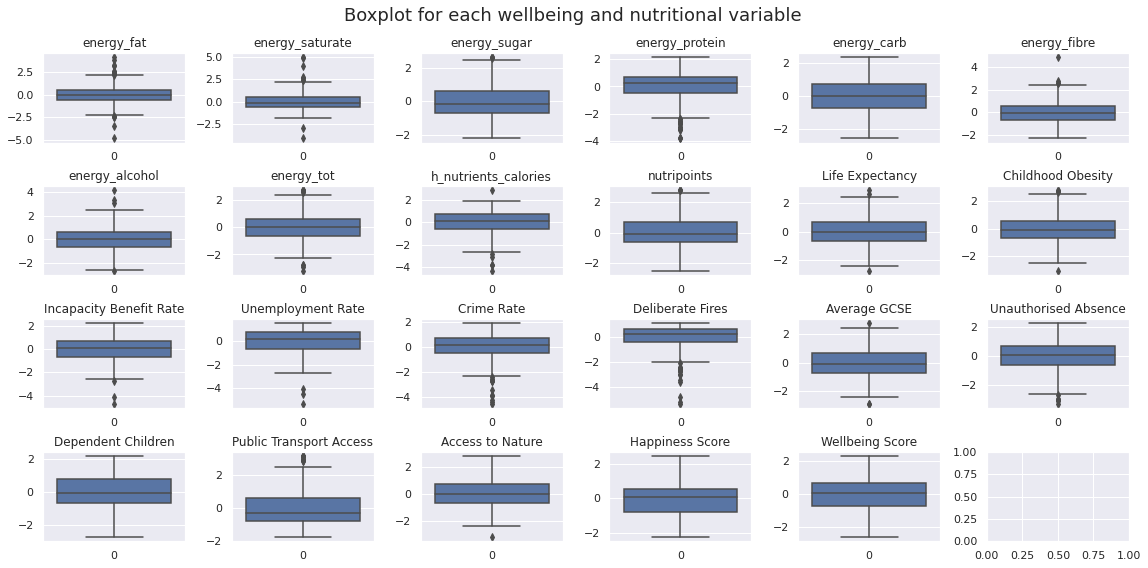

In [18]:
# Explanatory data analysis: visually show the distribution of the values for each variable thanks to boxplot
fig, ax = plt.subplots(4, 6, figsize=(16, 8), sharey=False)

for i in range(len(COLUMNS)):
    sbplt = ax[int(i/6), i % 6]

    sns.boxplot(data=wellbeing_grocery_analysis.iloc[:, i], ax=sbplt)
    sbplt.set_xlabel('')
    sbplt.set_ylabel('')
    sbplt.set_title(COLUMNS[i], loc='center', wrap=True)

fig.tight_layout()
fig.subplots_adjust(top=0.9)

fig.suptitle('Boxplot for each wellbeing and nutritional variable', fontsize=18)

These box plots give us a general view of the distribution of each variable. Since we would like to cluster nutrient data for specific areas and predict nutritional habits according to well-being characteristics, it is important to observe differences between areas for the various features. Here, the nutritional as well as the well-being features seem to take many values depending on the ward. Therefore, it is meaningful to understand if these differences in the nutritional variables are linked to differences in the well-being features. Moreover, some outliers can sometimes be seen, for example for the energy_saturate and the crime rate. 

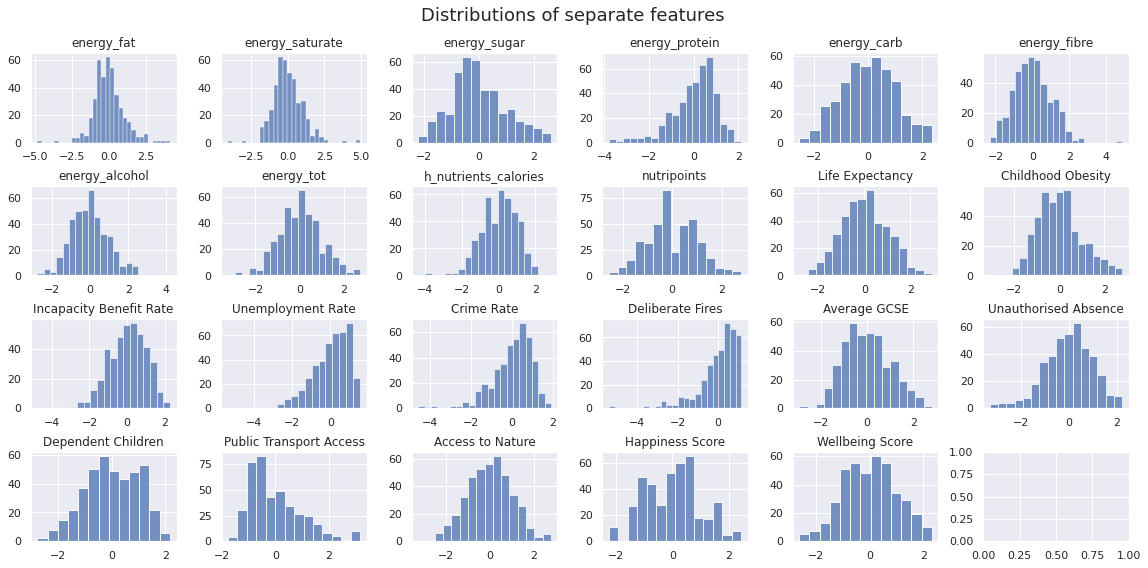

In [19]:
# Exploratory data analysis: distribution of the different variables by counting the number of observations per value
fig, ax = plt.subplots(4, 6, figsize=(16, 8), sharey=False)

for i in range(len(COLUMNS)):
    sbplt = ax[int(i / 6), i % 6]

    sns.histplot(wellbeing_grocery_analysis.iloc[:, i], ax=sbplt)
    sbplt.set_xlabel('')
    sbplt.set_ylabel('')
    sbplt.set_title(COLUMNS[i], wrap=True)

fig.tight_layout()
fig.subplots_adjust(top=0.9)

fig.suptitle('Distributions of separate features', fontsize=18);

# plt.savefig("distribution_features.svg")

It seems that some variables, as "Access to nature" and "Life Expectancy", follow a normal distribution. Let's check our assumption!

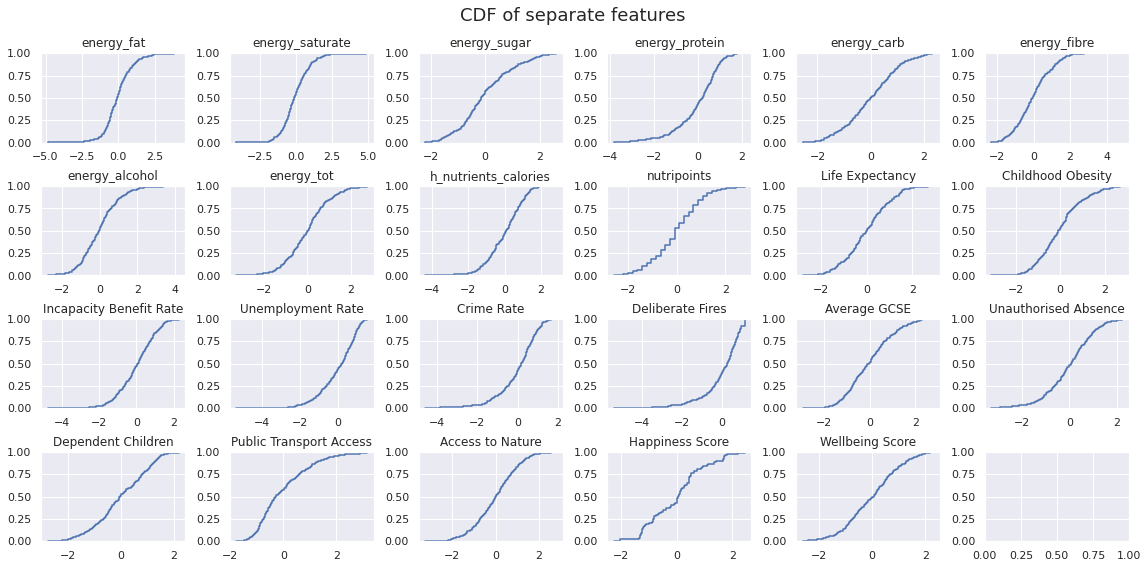

In [20]:
# Explanatory data analysis: distribution of the different variables by computing the proportion of values below or equal
# to a certain value
fig, ax = plt.subplots(4, 6, figsize=(16, 8), sharey=False)

for i in range(len(COLUMNS)):
    sbplt = ax[int(i / 6), i % 6]

    sns.ecdfplot(wellbeing_grocery_analysis.iloc[:, i], ax=sbplt)
    sbplt.set_xlabel('')
    sbplt.set_ylabel('')
    sbplt.set_title(COLUMNS[i], wrap=True)

fig.tight_layout()
fig.subplots_adjust(top=0.9)

fig.suptitle('CDF of separate features', fontsize=18);

We observe districumulative distribution function of the format of a normal distribution, it seems that certain variables follow this kind of distribution.

We will now test it more thoroughly using three different tests to check normality. We set the significance level to $\alpha = 0.05$, and only accept the columns that pass every test.

In [21]:
# check for any normal distribution
from collections import defaultdict
from scipy.stats import shapiro, normaltest
alpha = 0.05


results = defaultdict(list)
# normality test
for col in COLUMNS:
    data = wellbeing_grocery_analysis[col]
    stat_shap, pvalue_shap = shapiro(data)
    stat_normal, pvalue_normal = normaltest(data)
    stat_kstest, pvalue_kstest = diagnostic.kstest_normal(data, dist='norm')
    passed_tests = np.sum(
        np.array([pvalue_shap, pvalue_normal, pvalue_kstest]) > alpha)
    if passed_tests:
        # failed to reject H0
        results['Factor'].append(col)
        results['Passed Tests'].append(passed_tests)

display(pd.DataFrame(results).sort_values("Passed Tests", ascending=False))

,Factor,Passed Tests
0,energy_carb,3
2,energy_tot,3
4,Life Expectancy,3
8,Access to Nature,3
9,Wellbeing Score,3
3,nutripoints,2
1,energy_fibre,1
5,Incapacity Benefit Rate,1
6,Average GCSE,1
7,Unauthorised Absence,1


The second value returned by the function is the p-value. When the p_value < 0.05 -> we can reject the null hypothesis that the data comes from a normal distribution!
Here, we observe that:

- energy_carb
- energy_tot
- Life Expectancy
- Access to Nature
- Well-being Score

have a p-value > 0.05 for all normality test.

Therefore, the null hypothesis is not rejected and we can say that those variables follow a normal distribution.

### B) Correlation study

After checking how each variable is distributed: its interval, mean and standard deviation, we will now observe the correlation between our Nutripoints, representative of nutritional informations, and each well-being variable.

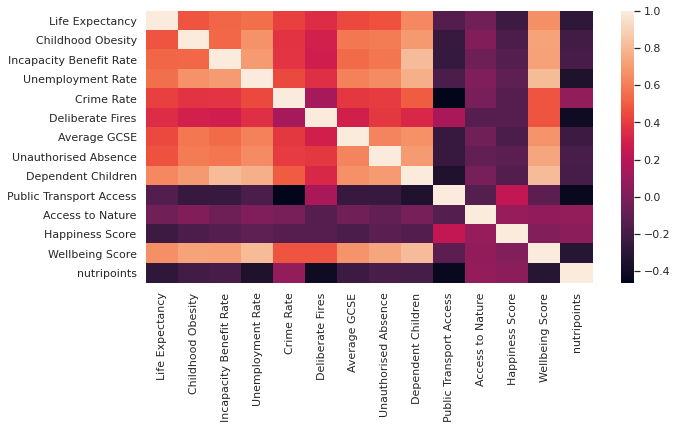

In [22]:
# Computing and plotting the correlation between the well-being scores and nutripoints
correlation = wellbeing_grocery_analysis[COLUMNS_SCORES +
                                         ['nutripoints']].corr()
correlation.to_pickle("plot_data/wellbeing_correlation.pkl")

fig = plt.figure(figsize=(10, 5))

sns.heatmap(correlation);

This heatmap helps us visualize the correlation between the different variables. If we focus on the correlation between Nutripoints and wellbeing features (last row), we can see actually that the values are quite low because the color is mainly purple corresponding to the negative correlation values and they are all below 0.4 which is not high. This is not a good augur for the continuation of the project.

In [23]:
# Computing the correlation between the different variables from the dataset according to the spearman method

correlation = wellbeing_grocery_analysis.corr(method="spearman")

From the results obtained thanks to the heatmap, we decided to analyze if it was only the nutripoints that did not have a high correlation with the well-being variables or if we could also observe this phenomenom for the other nutritional variables (energy and entropy).

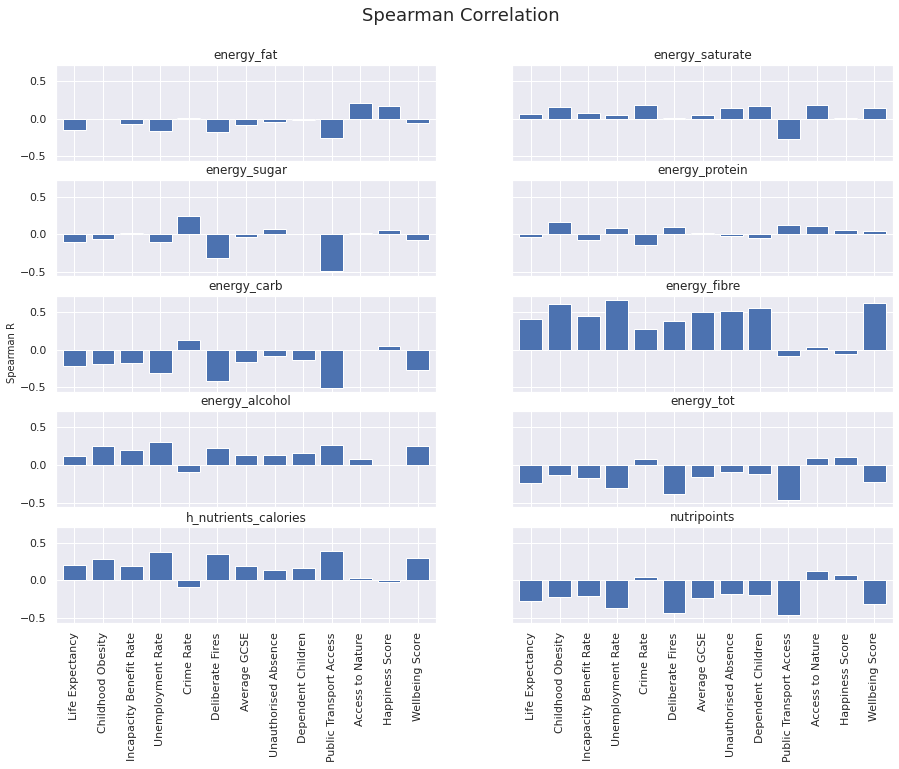

In [24]:
# Plotting the correlation between the nutritional and the well-being variables

fig, ax = plt.subplots(5, 2, figsize=(15, 10), sharex=True, sharey=True)

for i in range(len(COLUMNS_GROCERY)):
    sbplt = ax[int(i / 2), i % 2]

    correlation[COLUMNS_GROCERY[i]][COLUMNS_SCORES].plot.bar(
        x=None, y=None, width=0.8, legend=None, ax=sbplt)
    sbplt.set_title(wellbeing_grocery_analysis.columns[i], wrap=True)


fig.text(0.08, 0.5, 'Spearman R', va='center', rotation='vertical')
fig.subplots_adjust(top=0.9)

fig.suptitle("Spearman Correlation", fontsize=18);

We can observe on the graphs above that the correlation is low for all the nutritional variables. They never exceed 0.5 except for energy_fibre. Therefore, it seems that it is going to be difficult to predict the nutripoint from the well-being variables because they only have a small impact on the nutritional aspect of an area. Especially the Happiness Score is hardly correlated to any nutritional value.

### C) Regression analysis

We have seen that well-being variables are not very correlated to the nutritional ones. However, to be sure about it, we want to test some regressions and observe the R-squared and p-values for each coefficient.

We will try predicting entropy and fibre (the nutritional values with the highest correlation), with the well-being variables that seem, in our opinion, the most linked to nutrition.

Indeed, we could think that if unemployement is high, people have less money to spend on healthy food. Furthermore, childhood obesity must be linked to unhealthy food, high in fat and sugar.

In [25]:
COLUMNS_CORRELATED = ["Life Expectancy", "Incapacity Benefit Rate",
                      "Unemployment Rate", "Crime Rate", "Childhood Obesity", "Access to Nature"]

# Selection of the wellbeing features that seem most correlated to nutrition
reg_features = 'Q("Life Expectancy") + Q("Incapacity Benefit Rate") + Q("Unemployment Rate") + Q("Crime Rate") \
+ Q("Childhood Obesity") + Q("Access to Nature")'

# Linear regression to predict entropy from those features
mod = smf.ols(formula='h_nutrients_calories ~ ' +
              reg_features, data=wellbeing_grocery_analysis)
res = mod.fit()
print(res.summary());

                             OLS Regression Results                             
Dep. Variable:     h_nutrients_calories   R-squared:                       0.245
Model:                              OLS   Adj. R-squared:                  0.234
Method:                   Least Squares   F-statistic:                     21.98
Date:                  Fri, 18 Dec 2020   Prob (F-statistic):           2.02e-22
Time:                          23:43:44   Log-Likelihood:                -529.33
No. Observations:                   414   AIC:                             1073.
Df Residuals:                       407   BIC:                             1101.
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [26]:
# Linear regression to predict energy_fibre
mod = smf.ols(formula='energy_fibre ~ ' + reg_features,
              data=wellbeing_grocery_analysis)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           energy_fibre   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     52.48
Date:                Fri, 18 Dec 2020   Prob (F-statistic):           9.22e-48
Time:                        23:43:44   Log-Likelihood:                -468.83
No. Observations:                 414   AIC:                             951.7
Df Residuals:                     407   BIC:                             979.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

R-squared are quite low meaning that either 20% or 40% of the data can be predicted. Furthermore, the p-values of the the coefficients should be below 0.05 in order to be meaningful, which they are not, unless for childhood obesity when predicting the entropy.

### D) PCA

Now, we do a PCA to project the well-being data into a 2D plane.

In [27]:
# PCA on the nutrition features

wellbeing_grocery_analysis = wellbeing_grocery[COLUMNS_GROCERY]\
    .dropna().copy()

wellbeing_grocery_reduced_pca = PCA(n_components=2).fit_transform(
    wellbeing_grocery_analysis)

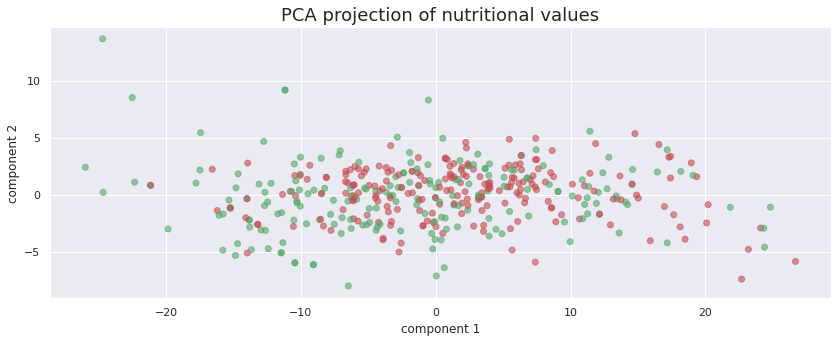

In [28]:
# Labels computed as explained above
labels = wellbeing_grocery.apply(
    lambda row: "g" if row['Wellbeing Score'] >= 0 else "r", axis=1)

# Plot the data reduced to a 2D plane with PCA
plt.figure(figsize=(14, 5))
plt.scatter(wellbeing_grocery_reduced_pca[:, 0],
            wellbeing_grocery_reduced_pca[:, 1], c=labels, alpha=0.6)
plt.xlabel('component 1')
plt.ylabel('component 2')

plt.title("PCA projection of nutritional values", fontsize=18);

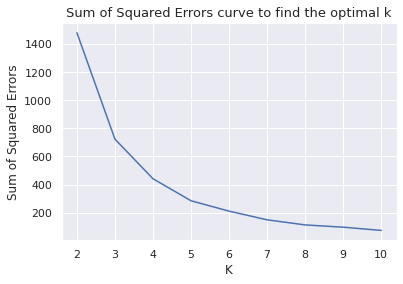

In [29]:
# Election of the column we would like to determine the number of clusters for: here it is the Nutripoints
year_grocery = year_grocery.sort_values(by=["nutripoints"])

columns_kmeans = ['nutripoints']
year_grocery_kmeans = year_grocery[columns_kmeans].copy()

# Function to plot the sse


def plot_sse(X, start=2, end=11):
    sse = []
    for k in range(start, end):
        # Assign the labels to the clusters
        kmeans = KMeans(n_clusters=k, random_state=10).fit(X)
        sse.append({"k": k, "sse": kmeans.inertia_})
    sse = pd.DataFrame(sse)
    # Plot the data
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")
    plt.title("Sum of Squared Errors curve to find the optimal k", fontsize=13)


plot_sse(year_grocery_kmeans)

### E) k-Means Clustering to Label Data

In order to better understand how nutripoints are spread and to see if we can identify some clusters linked to well-being features, we will process the data using K-means.

We know that a positive value corresponds to a better score than the England average whereas the negative are worse. We could then label our datapoints with respect to their wellbeing score (value comptued from all well-being variables, higher corresponds to a better well-being estimate). We set the color of positive well-being scores to green, negative to red. Unfortunately, the nutritional values do not seem create clusters or visually separate depending on the well-being score.

We will now label the data based on its nutripoints. We apply this to `year_grocery` as we want to take the distribution for all the wards and not only the ones for which we also have wellbeing values.

To understand how many clusters we can determine for the nutripoints, we first plot the sum of squared erros curve for each number of cluster in order to find the optimal number k. It is called the elbow method. Indeed, the point where the curve actually breaks should be the best number of clusters for this dataset. 
To confirm our choice, we will also do the silhouette score. This curve represents the score assessed for each number of clusters considering the separation distance between the resulting clusters. A peak on the curve indicates that the score reached its global maximum at the optimal k. 

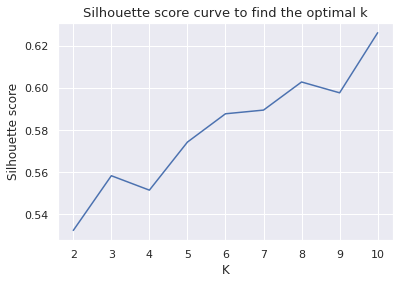

In [30]:
# 2nd method to choose k: the silhouette score
silhouettes = []

# Trying for k between 2 and 10
for k in range(2, 11):
    # Cluster the data and assign the labels
    labels = KMeans(n_clusters=k, random_state=10).fit_predict(
        year_grocery_kmeans)
    # Get the Silhouette score
    score = silhouette_score(year_grocery_kmeans, labels)
    silhouettes.append({"k": k, "score": score})

# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)

# Plot the data
plt.plot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")
plt.title("Silhouette score curve to find the optimal k", fontsize=13);

On the sse plot, we can observe an elbow for k=3 and k=5. On the other hand, when plotting the silhouette score, we see that the curve goes down for k=3 but the silhouette score is higher for k=5. Therefore, we decided to divide the nutripoints into 5 clusters. To do so, we use the K-means method. We also rank the areas from the lowest nutripoints to the biggest.

In [31]:
# Clustering the data with the current number of clusters
kmean = KMeans(n_clusters=5, random_state=42).fit(year_grocery_kmeans)

# sort labels according to center
idx = np.argsort(kmean.cluster_centers_.sum(axis=1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(5)

# Plotting the data by using the labels as color
year_grocery['nutri_class'] = lut[kmean.labels_]

In [32]:
display(year_grocery.head())
print(year_grocery.shape)
print(wellbeing_grocery.shape)

,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,nutri_class
488,E05009310,67.776372,26.173163,30.149908,20.482709,52.921834,2.972195,3.388133,147.541243,1.680088,-1.5,0
542,E05009400,74.997843,30.267747,33.156419,21.588604,59.817294,3.103980,1.973678,161.481399,1.619959,0.5,0
476,E05000643,76.027079,30.271501,35.110675,20.979538,61.437904,3.009764,1.653409,163.107694,1.597898,1.0,0
486,E05009302,72.005495,29.177570,36.164185,20.553133,61.994290,3.037125,3.490972,161.081015,1.656259,1.0,0
463,E05000630,74.221496,30.006140,35.418521,20.519115,59.341674,3.072843,1.195961,158.351088,1.588668,1.0,0


(510, 12)
(414, 25)


In [33]:
year_grocery.to_pickle("data/grocery_nutripoints.pkl")

The `year_grocery` database with the Nutripoints and the class they are assigned to will be saved into pickle in order to be reused in another file such as  `Nutripoints` where we analyse in more details the distribution of the different clusters and the part `fastfood` where we want to study another correlation.

In [34]:
# Merging the 2 datasets of interest: year grocery and wellbeing scores according to the ward name
wellbeing_grocery_pca = pd.merge(
    left=year_grocery, right=wellbeing_scores, left_on='area_id', right_on="New ward code")

wellbeing_grocery_pca = wellbeing_grocery_pca.drop("New ward code", axis=1)

In [35]:
# PCA on the wellbeing features

wellbeing_grocery_analysis = wellbeing_grocery_pca[COLUMNS_CORRELATED]\
    .dropna().copy()

wellbeing_grocery_reduced_pca = PCA(n_components=2).fit_transform(
    wellbeing_grocery_analysis)

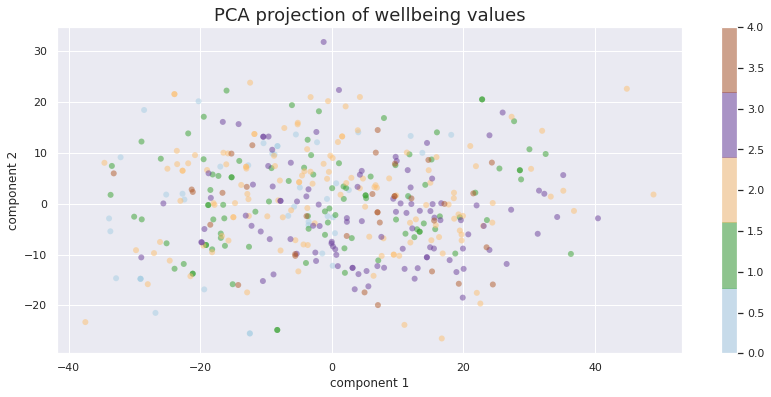

In [36]:
# Plot the data reduced to a 2D plane with PCA
color = wellbeing_grocery_pca["nutri_class"].values
plt.figure(figsize=(14, 6))
# plt.scatter(wellbeing_grocery_reduced_pca[:, 0],
#            wellbeing_grocery_reduced_pca[:, 1], c=color, alpha=0.6)

plt.scatter(wellbeing_grocery_reduced_pca[:, 0],
            wellbeing_grocery_reduced_pca[:, 1],
            c=color, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Paired', 5))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()

plt.title("PCA projection of wellbeing values", fontsize=18);

The different colors correspond to the nutri_class every datapoint is in. Again, the correlated features do not seem to be enough to separate the nutripoints into clear clusters.

### F) Equivalence Test

Our visual analysis suggests that there is no significant relationship between a general well-being score and nutritional quality of an area. To formalize this intuition, we will perform an equivalence test. Equivalence tests are a variation of hypothesis tests used to draw statistical inferences from observed data. In equivalence tests, the null hypothesis is defined as an effect large enough to be deemed interesting, specified by an equivalence bound. The alternative hypothesis is any effect that is less extreme than said equivalence bound. The observed data is statistically compared against the equivalence bounds.

If the statistical test indicates the observed data is surprising, assuming that true effects at least as extreme as the equivalence bounds, a Neyman-Pearson approach to statistical inferences can be used to reject effect sizes larger than the equivalence bounds with a pre-specified Type 1 error rate.

In [37]:
def classify_wellbeing(row, column):
    if row[column] > 0:
        return "prosperous"
    else:
        return "unpropitious"


wellbeing_grocery["prosperity"] = wellbeing_grocery.apply(
    lambda row: classify_wellbeing(row, "Wellbeing Score"), axis=1)

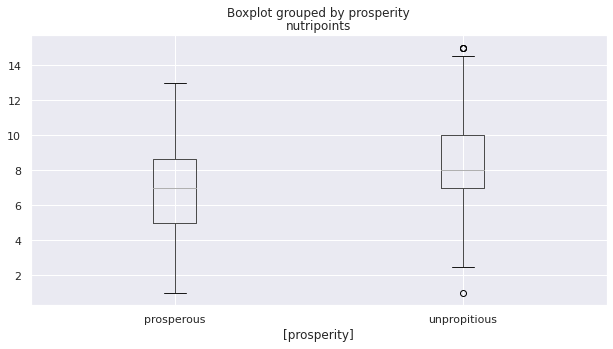

In [38]:
wellbeing_grocery[['nutripoints', 'prosperity']
                  ].boxplot(by='prosperity', figsize=(10, 5))

plt.show()

Assuming that the threshold value for a practical difference in nutripoint is 1, the null and alternative hypotheses would be:

$H_0: |\mu_1 - \mu_2| \geq 1$

$H_1: |\mu_1 - \mu_2| < 1$

In [39]:
p_values = []

for col in COLUMNS_SCORES:
    median_col = wellbeing_grocery[col].median()

    if col in ("Average GCSE",
               "Public Transport Access",
               "Access to Nature",
               "Happiness Score",
               "Wellbeing Score"):
        wellbeing_grocery["prosperity"] = wellbeing_grocery.apply(
            lambda row: classify_wellbeing(row, col), axis=1)
    else:
        wellbeing_grocery["prosperity"] = wellbeing_grocery.apply(
            lambda row: classify_wellbeing(-1 * row, col), axis=1)

    treated = wellbeing_grocery[wellbeing_grocery['prosperity']
                                == "prosperous"]['nutripoints']
    control = wellbeing_grocery[wellbeing_grocery['prosperity']
                                == "unpropitious"]['nutripoints']

    p_value_non_equivalence, lower_threshold_test, upp_threshold_test = ttost_ind(
        x1=control, x2=treated, low=-1, upp=1)

    p_values.append(p_value_non_equivalence)


# multiple tests correction
rejected, p_values_corrected, _, _ = multipletests(p_values)

for p_value_non_equivalence, col in zip(p_values_corrected, COLUMNS_SCORES):

    test_result = "H_0 rejected" if p_value_non_equivalence < 0.05 else "H_0 not rejected"
    print(f"{test_result} for {col}, p-value: {p_value_non_equivalence:.2e}")
    # print(lower_threshold_test)
    # print(upp_threshold_test)

H_0 not rejected for Life Expectancy, p-value: 9.83e-01
H_0 not rejected for Childhood Obesity, p-value: 9.64e-01
H_0 not rejected for Incapacity Benefit Rate, p-value: 9.64e-01
H_0 not rejected for Unemployment Rate, p-value: 1.00e+00
H_0 not rejected for Crime Rate, p-value: 1.52e-01
H_0 not rejected for Deliberate Fires, p-value: 1.00e+00
H_0 not rejected for Average GCSE, p-value: 9.17e-01
H_0 not rejected for Unauthorised Absence, p-value: 9.64e-01
H_0 not rejected for Dependent Children, p-value: 9.99e-01
H_0 not rejected for Public Transport Access, p-value: 1.00e+00
H_0 not rejected for Access to Nature, p-value: 1.27e-01
H_0 not rejected for Happiness Score, p-value: 3.84e-01
H_0 not rejected for Wellbeing Score, p-value: 1.00e+00


As in traditional hypothesis testing, the aim of our equivalence test is to reject the null hypothesis in order to conclude that the alternative hypothesis is demonstrated beyond reasonable doubt. In our case, if we can reject the null hypothesis $H_0$ (that the difference between the two groups is higher than or equal to 1), we are allowed to conclude that the mean difference between the groups at the population level is below 1, a value defined as trivial.
The `treatment` is having a positive well-being score.

However, we can not conclude that the effect of the experimental treatment is practically insignificant, as the null hypothesis is not rejected for any feature.

## IV) Predictive Models

We have seen that there are some columns with a considerable correlation between well-being features and our computed nutripoints. Therefore, we will now try to predict the nutripoints from these well-being features and assess the quality of the model.

In [40]:
X = wellbeing_grocery[COLUMNS_CORRELATED]
y = wellbeing_grocery[["nutripoints"]]

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)
X_tr = X_tr.copy()
X_te = X_te.copy()

X_tr[X_tr.columns] = scaler_X.fit_transform(X_tr[X_tr.columns])
X_te[X_te.columns] = scaler_X.transform(X_te[X_te.columns])

y_tr = scaler_y.fit_transform(y_tr).ravel()
y_te = scaler_y.transform(y_te).ravel()

print(X_tr.shape, X_te.shape)

(331, 6) (83, 6)


### A) Train Regressor Models

In [41]:
# Regression models
models = {}

score_mse = 'neg_mean_squared_error'

<b>Life Expectancy</b>, <b>Incapacity Benefit Rate</b>, <b>Unemployment Rate</b>, <b>Crime Rate</b>, <b>Childhood Obesity</b> and <b>Access to Nature</b> are the selected variables for the prediction of the nutripoints, given their higher correlation with the nutripoints. We train a gradient boosting regressor, a ridge regressor and a random forest regressor. Given our low amount of training and test data, we want to avoid overfitting at all costs. That is why we tried to work with these more robust models. To find appropriate hyperparameters, we do a basic grid search using 10-fold cross-validation.

#### 1) Gradient Boosting Regression
We  will train a gradient boosting regressor. We decided to start with this model given our low amount of data samples. Ensemble methods like the gradient boosting regressor are known to be much more robust against over-fitting than simpler models like linear regression.

In [42]:
n_estim_list = np.arange(1, 101)

mse_train_gradboost = []
mse_val_gradboost = []

for n_estim in n_estim_list:
    gradboost = GradientBoostingRegressor(n_estimators=n_estim)

    scores_gradboost = cross_validate(gradboost, X_tr, y_tr, cv=10, return_train_score=True,
                                      scoring=(score_mse))

    mse_train_gradboost.append(-np.mean(scores_gradboost['train_score']))
    mse_val_gradboost.append(-np.mean(scores_gradboost['test_score']))

In [43]:
ind = np.argmin(mse_val_gradboost)
opt_param_gradboost = n_estim_list[ind]
opt_mse_val_gradboost = mse_val_gradboost[ind]

print("n =", opt_param_gradboost)

models["gradboost"] = (opt_mse_val_gradboost, opt_param_gradboost)

n = 42


#### 2) Ridge Regression

In [44]:
alphas_list = np.linspace(start=0.1, stop=10, num=100)

mse_train_ridge = []
mse_val_ridge = []

for a in alphas_list:
    ridge = Ridge(alpha=a)

    scores_ridge = cross_validate(ridge, X_tr, y_tr, cv=10, return_train_score=True,
                                  scoring=(score_mse))

    mse_train_ridge.append(-np.mean(scores_ridge['train_score']))
    mse_val_ridge.append(-np.mean(scores_ridge['test_score']))

In [45]:
ind = np.argmin(mse_val_ridge)
opt_param_ridge = alphas_list[ind]
opt_mse_val_ridge = mse_val_ridge[ind]

print("alpha =", opt_param_ridge)

models["ridge"] = (opt_mse_val_ridge, opt_param_ridge)

alpha = 10.0


#### c) Random Forest Regression

In [46]:
mse_train_rf = []
mse_val_rf = []

for n_estim in n_estim_list:
    rf = RandomForestRegressor(n_estimators=n_estim)

    scores_rf = cross_validate(rf, X_tr, y_tr, cv=10, return_train_score=True,
                               scoring=(score_mse))

    mse_train_rf.append(-np.mean(scores_rf['train_score']))
    mse_val_rf.append(-np.mean(scores_rf['test_score']))

In [47]:
ind = np.argmin(mse_val_rf)
opt_param_rf = n_estim_list[ind]
opt_mse_val_rf = mse_val_rf[ind]

print("n_estimators =", opt_param_rf)
models["rf"] = (opt_mse_val_rf, opt_param_rf)

n_estimators = 64


### B) Model Selection

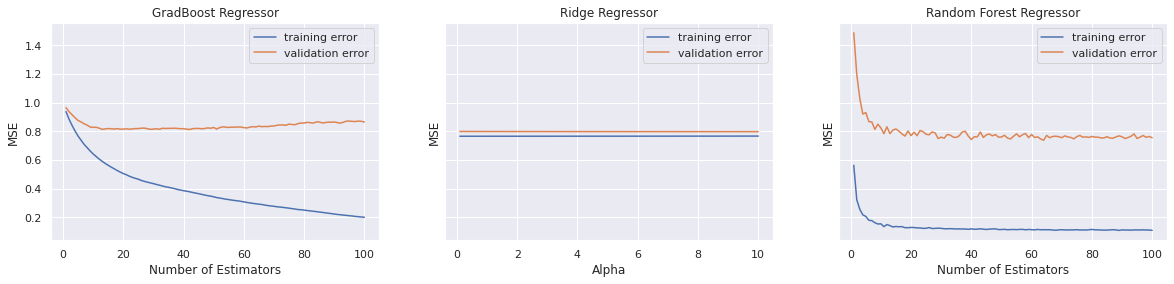

In [48]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4), sharey=True)

# GradBoost

line_1 = ax[0].plot(n_estim_list, mse_train_gradboost, label='training error')
line_2 = ax[0].plot(n_estim_list, mse_val_gradboost, label='validation error')
ax[0].set_xlabel('Number of Estimators')
ax[0].set_ylabel('MSE')
ax[0].set_title('GradBoost Regressor')
ax[0].legend()

##############################################

# Ridge

line_1 = ax[1].plot(alphas_list, mse_train_ridge, label='training error')
line_2 = ax[1].plot(alphas_list, mse_val_ridge, label='validation error')
ax[1].set_xlabel('Alpha')
ax[1].set_ylabel('MSE')
ax[1].legend()
ax[1].set_title('Ridge Regressor')


##############################################

# RandomForest

# print(x_arr, mse_train)
line_1 = ax[2].plot(n_estim_list, mse_train_rf, label='training error')
line_2 = ax[2].plot(n_estim_list, mse_val_rf, label='validation error')
ax[2].set_xlabel('Number of Estimators')
ax[2].set_ylabel('MSE')
ax[2].set_title('Random Forest Regressor')
ax[2].legend()

In [49]:
print(models)

{'gradboost': (0.8136252020360144, 42), 'ridge': (0.7980791907625584, 10.0), 'rf': (0.7380906223919244, 64)}


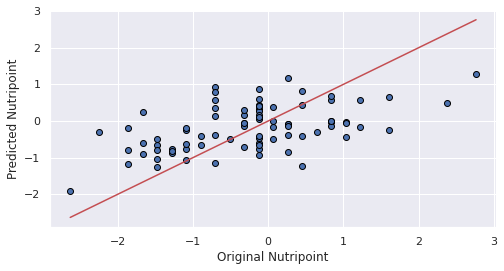

In [50]:
# Plot the results for the selected best model

gradboost = RandomForestRegressor(n_estimators=opt_param_rf)
gradboost.fit(X_tr, y_tr)

y_pred = gradboost.predict(X_te)

fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(y_te, y_pred, edgecolors=(0, 0, 0))
p1 = max(max(y_pred), max(y_te))
p2 = min(min(y_pred), min(y_te))
plt.plot([p1, p2], [p1, p2], 'b-', c='r')
ax.set_xlabel('Original Nutripoint')
ax.set_ylabel('Predicted Nutripoint')
plt.show()

# plt.savefig('regression_model_wellbeing.svg')

We finally test our results on the testing set and plot the results. The dots should be aligned close to the red line if the predictions were accurate.

We see that the best model's fit does not achieve a very good accuracy. Although the bias does not seem very high, the model does not achieve to grasp the variance of the data.

## V) Conclusions

We conclude that we were not able to successfully fit a generalizable model to predict the nutritional quality of an area from publicly available well-being data.

Reasons for this could be:

* Lack of training and test data.
* The models we fitted are not appropriate to this task, or more thorough hyperparameter tuning needed.
* Wards have a too high geographic granularity, smoothen out interesting effects.
* There is no underlying effect between well-being factors and nutripoints (nutritional quality of an area), or effect is very small.

## VI) Additional Analyses

### A) Nutripoints Analysis

Now, we will try to better understand how the health score (nutripoints) of the average products are distributed through the areas in London, how certain nutritional variables can influence it and what is the average nutrients composition of the average product of all the areas. 

We have decided to create the **nutripoints** variable to facilitate the prediction. Indeed, it is easier to predict one variable than all the nutritional ones. It therefore represents the healthiness of the average product of a specific area by taking into account the different nutrients it is based on.  

We based our computation of the nutripoints on the definition of the national french Nutri-Score. The bigger it is, the worst is the average product regarding the level of sugar, saturate, sodium and total energy it has. On the other hand, if it is negative (which is almost impossible), it represents products with higher level of proteins and fibers than "bad nutrients" (salt, sugar, saturate). We adapted the different ranges of the official formula to our database as we have average products and therefore very close data ranges. You can see the detailed function in the file: `utils.py`

Moreover, we realised than when summing the main nutrients (carb, protein, fibre, fat, salt), we didn't reach either the average product's weight or 100. Therefore, we rescaled all our values for a 100g in order to be able to compare the different areas. 

#### Data Imports

We import `year_grocery` in order to obtain the weight of each nutrients and to compute the total weight for the typical London product analysis.

We also use `wellbeing_grocery` from the `main` notebook where `nutripoints` and `nutri_class` are already computed. However, we select only the columns referring to nutrition variables.

Usually perceived as "bad" nutrients, salt and sugar are consumed excessively in the total proportion of intakes. On the other hand, saturate, also classified as an unhealthy nutrient is consumed reasonably with a value that doesn't exceed the recommendations. 

In [51]:
# Data Imports

year_grocery = pd.read_csv("data/year_osward_grocery.csv")
display(year_grocery.head())

wellbeing_grocery = pd.read_pickle("data/wellbeing_grocery.pkl")

grocery_analysis = pd.read_pickle("data/grocery_nutripoints.pkl")
display(grocery_analysis.head())
print(grocery_analysis.shape)

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,man_day,population,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km
0,E05000026,449.535137,32.5,166.4,300.0,500.0,1500.0,771.349423,3.716832,125.960833,...,37315,14370.0,7469.0,6901.0,4211.0,9421.0,738.0,29.572999,1.26,11404.761905
1,E05000027,413.130263,32.5,150.0,300.0,500.0,1500.0,626.395178,5.164174,110.664114,...,14474,10845.0,5228.0,5617.0,3205.0,6608.0,1032.0,33.568004,1.36,7974.264706
2,E05000028,407.100472,32.5,160.0,300.0,500.0,1200.0,545.890959,2.710677,121.990710,...,32138,13856.0,6750.0,7106.0,4180.0,8537.0,1139.0,32.032693,1.29,10741.085271
3,E05000029,384.173858,30.0,150.0,250.0,454.0,1500.0,591.837557,4.968373,122.245578,...,16223,10850.0,5300.0,5550.0,3023.0,6251.0,1576.0,36.004793,3.38,3210.059172
4,E05000030,356.882607,30.0,140.0,250.0,450.0,1000.0,465.284180,3.880963,109.959688,...,17522,11348.0,5515.0,5833.0,2747.0,6961.0,1640.0,37.247444,3.45,3289.275362


,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,nutri_class
488,E05009310,67.776372,26.173163,30.149908,20.482709,52.921834,2.972195,3.388133,147.541243,1.680088,-1.5,0
542,E05009400,74.997843,30.267747,33.156419,21.588604,59.817294,3.103980,1.973678,161.481399,1.619959,0.5,0
476,E05000643,76.027079,30.271501,35.110675,20.979538,61.437904,3.009764,1.653409,163.107694,1.597898,1.0,0
486,E05009302,72.005495,29.177570,36.164185,20.553133,61.994290,3.037125,3.490972,161.081015,1.656259,1.0,0
463,E05000630,74.221496,30.006140,35.418521,20.519115,59.341674,3.072843,1.195961,158.351088,1.588668,1.0,0


(510, 12)


#### Adding labels and adding color

In order to study better the repartition of these Nutritpoints, we will create two columns: one with the label corresponding to each cluster and another one with the corresponding color. 

We based our label and color assessment on the French Nutri-Score scale and rules.

**Let's have a closer look at the nutrients associated with an unhealthy diet: salt, sugar and saturate:**

In [52]:
grocery_analysis.groupby("nutri_class").min()

,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints
nutri_class,,,,,,,,,,,
0,E05000045,67.111854,26.173163,30.149908,18.157465,52.921834,2.880780,1.195961,147.541243,1.569763,-1.5
1,E05000050,72.956706,27.800358,33.394489,17.661997,60.035872,2.857497,1.202308,164.442384,1.545611,4.5
2,E05000032,76.529701,29.169969,34.850071,18.375916,64.492046,2.750710,0.916022,172.426498,1.530007,7.0
3,E05000030,78.434285,29.826159,37.800908,18.720815,70.666821,2.788545,0.941336,177.672079,1.513248,9.0
4,E05000026,79.921223,31.345191,42.518834,17.596480,74.299701,2.780206,0.715793,183.025671,1.465237,11.5


#### Nutrilabel

In [53]:
# Converting nutri class (from 0 to 4) into letters (from A to E) called the nutrilabel
def nutri_labels_to_letter(row_list):
    if row_list == 0:
        return "A"
    elif row_list == 1:
        return "B"
    elif row_list == 2:
        return "C"
    elif row_list == 3:
        return "D"
    elif row_list == 4:
        return "E"
    else:
        return ""


grocery_analysis["nutrilabel"] = grocery_analysis.apply(
    lambda row: nutri_labels_to_letter(row["nutri_class"]), axis=1)

#### Nutricolor

In [54]:
# Function to set a color to each label
def addcolor(row_list):
    if row_list == "A":
        return "#038141"
    elif row_list == "B":
        return "#85BB2F"
    elif row_list == "C":
        return "#FECC02"
    elif row_list == "D":
        return "#EE8300"
    elif row_list == "E":
        return "#E63F11"
    else:
        return ""


grocery_analysis["color"] = grocery_analysis.apply(
    lambda row: addcolor(row["nutrilabel"]), axis=1)
display(grocery_analysis.head())

,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,nutri_class,nutrilabel,color
488,E05009310,67.776372,26.173163,30.149908,20.482709,52.921834,2.972195,3.388133,147.541243,1.680088,-1.5,0,A,#038141
542,E05009400,74.997843,30.267747,33.156419,21.588604,59.817294,3.103980,1.973678,161.481399,1.619959,0.5,0,A,#038141
476,E05000643,76.027079,30.271501,35.110675,20.979538,61.437904,3.009764,1.653409,163.107694,1.597898,1.0,0,A,#038141
486,E05009302,72.005495,29.177570,36.164185,20.553133,61.994290,3.037125,3.490972,161.081015,1.656259,1.0,0,A,#038141
463,E05000630,74.221496,30.006140,35.418521,20.519115,59.341674,3.072843,1.195961,158.351088,1.588668,1.0,0,A,#038141


#### Exploratory data analysis

We now try to understand how the nutripoints are distributed. We also want to know the density of each nutrilabel.
Moreover, we thought it was important to visualise the correlation between the Nutripoints and each energy as we based our calculations on nutrients weight. The scatter plots is another way to observe the impact of the energy on Nutripoints. 

#### a) Nutripoints distribution  

/home/xavi_oliva/Documents/EPFL/ML_course/venv/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


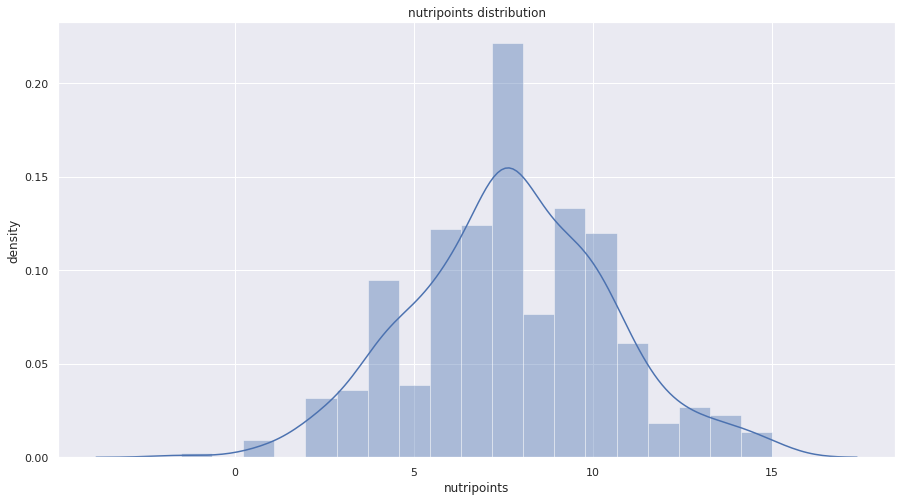

In [55]:
# Explanatory data analysis: distribution of different variables by counting the number of observations
plt.figure(figsize=(15, 8))

sns.distplot(grocery_analysis["nutripoints"])
plt.xlabel('nutripoints')
plt.ylabel('density')
plt.title('nutripoints distribution')
plt.show();

In [56]:
# checking if nutripoints follow a normal distribution
test_n, pvalue_n = diagnostic.kstest_normal(
    grocery_analysis.nutripoints, dist='norm')

alpha = 0.05

if pvalue_n < alpha:
    print(f"pvalue = {pvalue_n}: Null hypothesis rejected!")
else:
    print("Hypothesis not rejected.")

pvalue = 0.0009999999999998899: Null hypothesis rejected!


Here, the p_value < 0.05 -> we can reject the null hypothesis that the nutripoints comes from a normal distribution! We could actually observe it on the plot as the curve was not very smooth. 

We can observe that most of the values are between 4.5 and 12. There is not a lot of variance between our different average products. This explains why we are not able to observe precise clusters. Indeed, we force a bit the separation of the areas in different clusters. 

Energy_total is the most correlated to nutripoints with an R value of 0.9. It is followed by carb and sugar. A potent explanation could be that the C points in our Nutripoints computation, corresponding to the "bad" points have more weight than the good ones. Indeed, those values are higher, there is always more fat and carbs than there is protein and fibre. 

Furthermore, we can see that entropy is negatively correlated with Nutripoints. Therefore, an average product with equal proportion of each nutrient leads to good Nutripoints. This is explained by the fact that Nutripoints value fibre and protein and on the contrary when there is too much saturate, sugar or salt, it is badly classified. As a good entropy rhymes with the same level of each nutrient: fiber, protein, fat and carb, the points C will be close to points A, leading to small Nutripoints and a good label.

#### b) Nutrilabels distribution 

In order to know, which class has the more area, we plot the nutrilabel distribution. Indeed, it could help later to know if well-being variables play a role in that distribution.

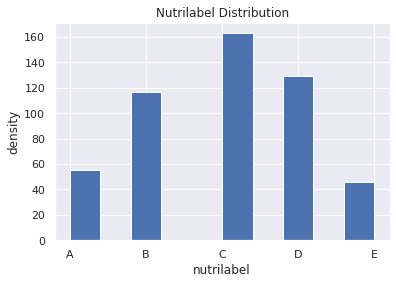

In [57]:
# Plot of the nutrilabel density distribution
plt.figure(figsize=(6, 4))

plt.hist(x=grocery_analysis["nutrilabel"])

plt.xlabel('nutrilabel')
plt.ylabel('density')
plt.title('Nutrilabel Distribution')

plt.show();

The boundary labels are the ones with fewer area. Indeed, most areas are aggregated and spread between B, C and D. C is the one with the most areas. A is the "best" class, while areas with D and E have more "unhealthy" average products with more salt, sugar and/or fat. If we sum A and B on one hand and C, D and E on the other side, we can observe that the second sum is higher than A+B. Therefore, most of the average products are in the less healthy classes.

However, we should not forget the nutripoints distribution, where we could observe that there was no big variance between the nutripoints in general. Therefore, the boundaries between each label are not very clear and the difference between labels is actually very small. Assessing that C is not healthy whereas B is actually not formally correct, we can only say that B products have mainly a better nutrition value than C products.

#### c) Index Score and Nutripoints

We add to our original database `wellbeing_nutripoints` a column with the Total Wellbeing Score per area.

In [58]:
wellbeing_nutripoints = pd.merge(left=grocery_analysis, right=wellbeing_grocery[['area_id', 'Index Score 2013']],
                                 on="area_id")
wellbeing_nutripoints.to_pickle("plot_data/plot_wellbeing_nutripoints.pkl")
display(wellbeing_nutripoints.head())

,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,nutri_class,nutrilabel,color,Index Score 2013
0,E05000643,76.027079,30.271501,35.110675,20.979538,61.437904,3.009764,1.653409,163.107694,1.597898,1.0,0,A,#038141,7.821723
1,E05000643,76.027079,30.271501,35.110675,20.979538,61.437904,3.009764,1.653409,163.107694,1.597898,1.0,0,A,#038141,-0.729017
2,E05000630,74.221496,30.006140,35.418521,20.519115,59.341674,3.072843,1.195961,158.351088,1.588668,1.0,0,A,#038141,7.699494
3,E05000053,67.111854,26.283257,38.057276,18.157465,66.365418,3.108847,1.360812,156.104396,1.581397,2.0,0,A,#038141,1.137273
4,E05000128,76.051862,31.107036,35.879753,19.998299,58.462154,3.150210,1.947443,159.609968,1.605121,2.0,0,A,#038141,2.828895


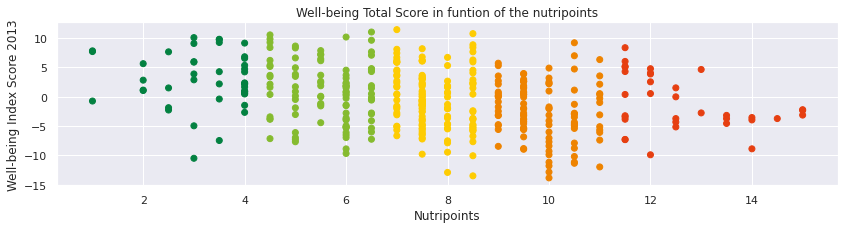

In [59]:
# Plotting the Wellbeing Total Score in function of the nutripoints
plt.figure(figsize=(14, 3))

plt.scatter(wellbeing_nutripoints["nutripoints"],
            wellbeing_nutripoints["Index Score 2013"], c=wellbeing_nutripoints["color"])

plt.xlabel("Nutripoints")
plt.ylabel("Well-being Index Score 2013")
plt.title("Well-being Total Score in funtion of the nutripoints")
plt.show()

From the above plot, we can better visualize the repartition of the nutrilabels. However, we cannot observe distinct clusters. Nutripoints follow a discrete distribution in the range of 1 to 15, while well-being scores are continuously distributed.

This plot confirms that there is no clear effect between nutrition and general well-being. Indeed, well-being index score is not decreasing with the Nutripoints. Some points in B have a very low Well-being Score while a point in E has high Index Score. In each nutrilabel, we have all sort of Index Score. Therefore, we cannot make conclusions on the impact of well-being on nutritional variables.

With the merging, we lost our outliers points from A label because we did not have their well-being value. 

#### Nutrients energy and Nutripoints correlation and influence

As we have seen, it is difficult to understand the effect of well-being on nutrition. We however want to observe the correlation between the nutrient energy and the Nutripoints as each nutrient play a role in the computation of this variable.

In [60]:
# Computing the correlation between the different variables from the dataset according to the spearman method
correlation = grocery_analysis.corr(method="spearman")
display(correlation)

,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,nutri_class
energy_fat,1.000000,0.823451,0.608459,-0.165126,0.585389,-0.029370,-0.365324,0.785848,-0.624390,0.739135,0.715755
energy_saturate,0.823451,1.000000,0.486850,-0.225230,0.378615,-0.047231,-0.221464,0.553098,-0.465406,0.597308,0.586171
energy_sugar,0.608459,0.486850,1.000000,-0.539847,0.855277,-0.270308,-0.451466,0.812268,-0.808285,0.832906,0.804209
energy_protein,-0.165126,-0.225230,-0.539847,1.000000,-0.346762,0.366865,0.325737,-0.212630,0.567731,-0.346873,-0.333549
energy_carb,0.585389,0.378615,0.855277,-0.346762,1.000000,-0.302417,-0.598661,0.943590,-0.875802,0.874585,0.840983
energy_fibre,-0.029370,-0.047231,-0.270308,0.366865,-0.302417,1.000000,0.181677,-0.196165,0.380603,-0.412804,-0.398273
energy_alcohol,-0.365324,-0.221464,-0.451466,0.325737,-0.598661,0.181677,1.000000,-0.530316,0.804910,-0.488289,-0.471550
energy_tot,0.785848,0.553098,0.812268,-0.212630,0.943590,-0.196165,-0.530316,1.000000,-0.821297,0.901864,0.869479
h_nutrients_calories,-0.624390,-0.465406,-0.808285,0.567731,-0.875802,0.380603,0.804910,-0.821297,1.000000,-0.822245,-0.791493
nutripoints,0.739135,0.597308,0.832906,-0.346873,0.874585,-0.412804,-0.488289,0.901864,-0.822245,1.000000,0.970086


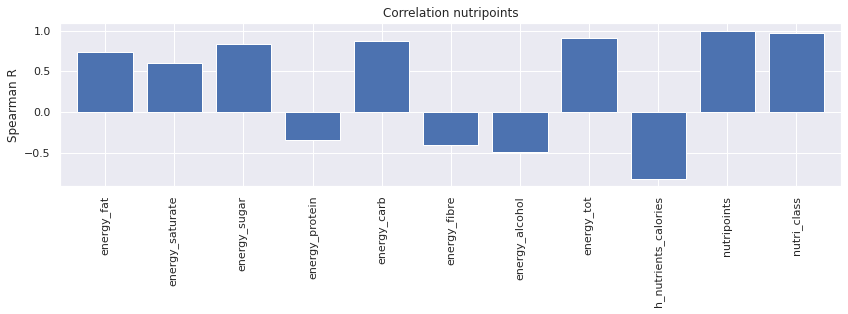

In [61]:
# Computing and plotting the correlation between the different nutrients and the nutripoints
plt.figure(figsize=(14, 3))
correlation["nutripoints"].plot.bar(x=None, y=None, width=0.8, legend=None)
plt.ylabel("Spearman R")
plt.title("Correlation nutripoints")
plt.show()

Unhealthy nutrients are positively correlated with nutripoints, which is expected (given the definition of nutripoints (see details on [website](https://xavoliva6.github.io/nutri_score/)). We additionally see that entropy is negatively correlated with nutripoints. Therefore, an average product with equal proportion of each nutrient leads to good nutripoints. This is explained by the fact that Nutripoints value fibre and protein and on the contrary when there is too much saturate, sugar or salt, it is badly classified. High entropy means a more equal distribution between nutrients.

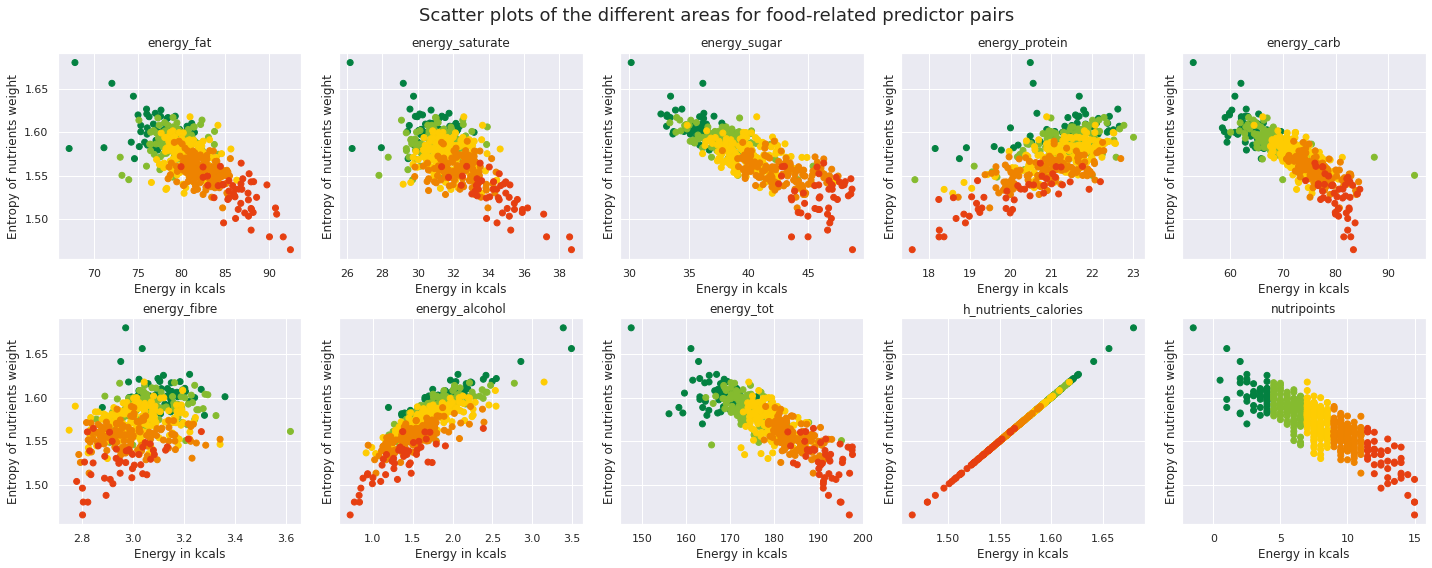

In [62]:
# Representation of ward areas according to their values for food-related predictor pairs
# Colors are set according to the nutrilabel of the area

fig, ax = plt.subplots(2, 5, figsize=(20, 8), sharey=True)

for i in range(10):
    sbplt = ax[int(i / 5), i % 5]
    sbplt.scatter(
        grocery_analysis.iloc[:, i + 1], grocery_analysis["h_nutrients_calories"], c=grocery_analysis["color"])

    sbplt.set_title(grocery_analysis.columns[i+1], wrap=True)
    sbplt.set(xlabel="Energy in kcals", ylabel="Entropy of nutrients weight")

fig.tight_layout()
fig.subplots_adjust(top=0.9)

fig.suptitle(
    'Scatter plots of the different areas for food-related predictor pairs', fontsize=18);

When representing entropy in function of each nutrient or nutripoints, we can observe their impact on this variable.

For instance, a low energy product would have a higher entropy than one with high energy. Indeed, high energy often means too much fat or carb which are very caloric taking place for other nutrients. It seems that most of A and B have lower total energy and therefore higher entropy. This decreasing trend can be observed for sugar and carb too but it is less distinct for fat and saturate. 

Moreover, increasing trend is more difficult to assess for protein and fibre. They are more aggregated in a corner of the graph.

When observing the Nutripoints figure, we can assess that indeed, the lowest entropy are part of D and E classes. 

#### Analysis of typical product in London

We want to analyze the distribution of the different nutrients in an average product. 

We therefore compute the average total_weight and average weight of each nutrients. We then represent them in a pie chart to visualize it better. 

We will try to compare this distribution with the reference intakes recommendation set by the European government. 

In [63]:
# Main classes of nutrients
NUTRIENTS = ["fibre", "protein", "carb", "fat", "salt"]
SUBNUTRIENTS = ["sugar", "saturate"]

In [64]:
# Creating a dataframe with all the nutrient's weight from year_grocery
weight = year_grocery[["area_id"]+NUTRIENTS].copy()

In [65]:
# Computing the total nutrient's weight
weight["weight_total"] = weight[NUTRIENTS].sum(axis=1)
display(weight.head())

,area_id,fibre,protein,carb,fat,salt,weight_total
0,E05000026,1.564721,4.977560,19.381951,9.488797,0.583240,35.996270
1,E05000027,1.581960,5.211694,18.950348,9.733634,0.568184,36.045821
2,E05000028,1.572323,5.192412,19.662048,9.216310,0.610536,36.253629
3,E05000029,1.550344,4.718184,20.084734,9.700137,0.533180,36.586579
4,E05000030,1.607947,5.307003,19.581403,9.381808,0.566784,36.444945


In [66]:
# Adding saturate and sugar values after computing the total weight since they are subcategories of nutrients
weight[['sugar', 'saturate']] = year_grocery[["sugar"] + ["saturate"]]
weight['carb_not_sugar'] = year_grocery["carb"]-year_grocery["sugar"]
weight['fat_not_saturate'] = year_grocery["fat"]-year_grocery["saturate"]
weight['not_saturate_sugar_salt'] = weight["weight_total"] - \
    year_grocery["saturate"]-year_grocery["sugar"]-year_grocery["salt"]
display(weight.head())

,area_id,fibre,protein,carb,fat,salt,weight_total,sugar,saturate,carb_not_sugar,fat_not_saturate,not_saturate_sugar_salt
0,E05000026,1.564721,4.977560,19.381951,9.488797,0.583240,35.996270,10.966213,3.693721,8.415738,5.795076,20.753096
1,E05000027,1.581960,5.211694,18.950348,9.733634,0.568184,36.045821,10.514427,3.565913,8.435921,6.167721,21.397297
2,E05000028,1.572323,5.192412,19.662048,9.216310,0.610536,36.253629,10.690272,3.613582,8.971776,5.602727,21.339238
3,E05000029,1.550344,4.718184,20.084734,9.700137,0.533180,36.586579,12.938606,3.961264,7.146128,5.738873,19.153528
4,E05000030,1.607947,5.307003,19.581403,9.381808,0.566784,36.444945,11.332898,3.614663,8.248505,5.767145,20.930600


In [67]:
# Computing the features for typical product in London wards based on the average weight of each nutrient
weight_mean = weight.mean(axis=0)
display(weight_mean)

fibre                       1.627422
protein                     5.267340
carb                       18.256906
fat                         9.028830
salt                        0.577493
weight_total               34.757991
sugar                      10.251251
saturate                    3.542424
carb_not_sugar              8.005655
fat_not_saturate            5.486406
not_saturate_sugar_salt    20.386823
dtype: float64

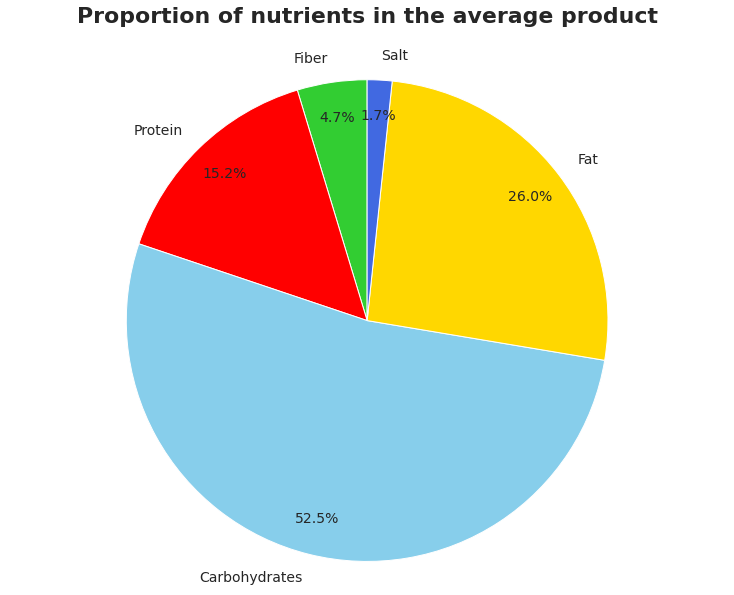

In [68]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
nutrients_labels = ["Fiber", "Protein", "Carbohydrates", "Fat", "Salt"]
colors = ["limegreen", "red", "skyblue", "gold", "royalblue"]
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(weight_mean[0:5], radius=1, labels=nutrients_labels,
        autopct='%1.1f%%', startangle=90, colors=colors, textprops={'fontsize': 14}, pctdistance=0.85)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Proportion of nutrients in the average product',
          fontsize=22, y=1.05, fontweight="bold")
plt.tight_layout(pad=0)
path = '../xavoliva6.github.io/img'
plt.savefig(f"{path}/proportion_nutrients_average_london.svg", format='svg',
            transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()

This pie chart visually shows the proportion of each nutrient in the average product in London. It will be compared to the recommendations for a healthy diet given by the [European law](https://www.nutrition.org.uk/attachments/article/234/Nutrition%20Requirements_Revised%20Oct%202016.pdf.)

Recommendations:   
Fats: 14%  
Fibres: 14%  
Carbs: 52%  
Protein: 10%  
Sodium: 1.2% \
Sugar: not more than 5%   
Saturate: not more than 11%   

By comparing the recommendations with the average product values, we find out that people in London eat too much fat and proteins. Moreover, the proportion of fibre in the Londoner diet is well below the recommendations. What about sugar, salt and saturate?

**Let's have a closer look at the nutrients associated with an unhealthy diet: salt, sugar and saturate:**

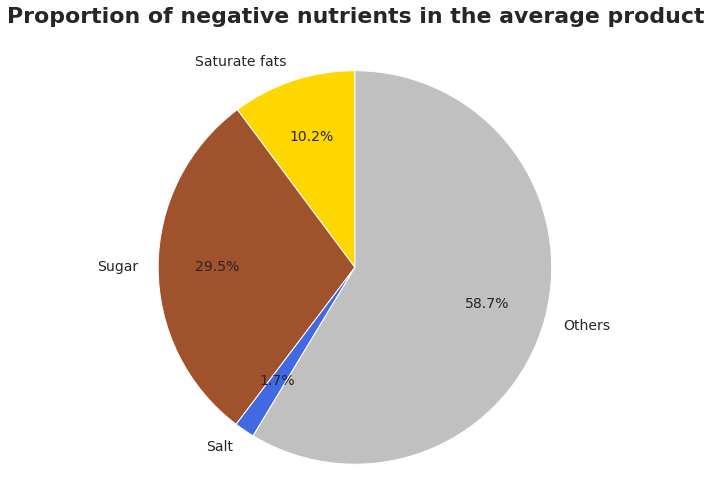

In [69]:
weight_sugar_saturate_salt = weight_mean[[
    "saturate", "sugar", "salt", "not_saturate_sugar_salt"]]

colors = ["gold", "sienna", "royalblue", "silver"]

subnutrients_labels = ["Saturate fats", "Sugar", "Salt", "Others"]
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(weight_sugar_saturate_salt, radius=1, labels=subnutrients_labels,
        autopct='%1.1f%%', startangle=90, colors=colors, textprops={'fontsize': 14}, pctdistance=0.7)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title(
    'Proportion of negative nutrients in the average product', fontsize=22, y=1.05, fontweight="bold")

plt.savefig(f"{path}/proportion_salt_sugar_saturate_average_london.svg", format='svg',
            transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()

Considered as "unhealthy" nutrients, salt and sugar are consumed in excess in the total proportion of intakes. On the other hand, saturated fats, also classified as an unhealthy nutrient, is consumed reasonably with a value that doesn't exceed the recommendations.

### B) House Prices Analysis

In this section, we will analyze data in a finer geographical granularity, to see if we can generate better predictions if we "zoom in". To do that, we use data in MSOA, which is smaller than a ward. We will consider a single feature, mean housing prices in a given area. The housing prices give a good indication of the financial wealth of its population.

#### Data imports

In [70]:
NUTRITION_COLS = ["area_id", "energy_tot", "energy_fat", "energy_saturate", "energy_sugar", "energy_protein",
                  "energy_carb", "energy_fibre", "energy_alcohol", "h_nutrients_calories"]

year_grocery_lsoa = pd.read_csv("data/year_lsoa_grocery.csv")
print(year_grocery_lsoa.shape)
display(year_grocery_lsoa.head())

(4833, 202)


,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,man_day,population,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km
0,E01000001,308.119047,35.0,150.0,250.0,400.0,900.0,266.851723,2.359404,97.218600,...,16033,1296.0,685.0,611.0,179.0,766.0,351.0,48.293981,0.13,9985.0
1,E01000002,313.517874,40.0,150.0,250.0,400.0,900.0,256.227843,2.833812,88.262314,...,7829,1156.0,616.0,540.0,197.0,656.0,303.0,47.398789,0.23,5061.0
2,E01000003,315.084751,35.0,150.0,250.0,400.0,1000.0,292.462262,2.763918,102.240558,...,15065,1350.0,713.0,637.0,152.0,850.0,348.0,48.360741,0.06,22843.0
3,E01000005,356.033437,38.0,150.0,280.0,450.0,1000.0,436.559315,2.554110,113.968805,...,25128,1121.0,604.0,517.0,294.0,675.0,152.0,35.611954,0.19,5912.0
4,E01000006,451.262063,36.0,180.0,325.0,500.0,1500.0,666.655869,7.744708,133.322097,...,5860,2040.0,1040.0,1000.0,563.0,1317.0,160.0,32.080392,0.15,13915.0


In [71]:
min_grocery = year_grocery_lsoa[['energy_tot', 'saturate', 'salt',
                            'sugar', 'f_fruit_veg', 'fibre', 'protein']].min(axis=0)

max_grocery = year_grocery_lsoa[['energy_tot', 'saturate', 'salt',
                            'sugar', 'f_fruit_veg', 'fibre', 'protein']].max(axis=0)

year_grocery_lsoa["nutripoints"] = year_grocery_lsoa.apply(
    lambda row: calculate_nutripoints(row, min_grocery, max_grocery), axis=1)

In [72]:
COLS = ["Code", "Year ending Dec 2014"]

housing_prices = pd.read_excel(
    "data/land-registry-house-prices-LSOA.xls", sheet_name="Mean")[COLS]
housing_prices.rename(
    columns={"Year ending Dec 2014": "mean house price"}, inplace=True)
housing_prices.dropna(inplace=True)

print(housing_prices.shape)
display(housing_prices.head())

(4835, 2)


,Code,mean house price
1,E01000001,853613
2,E01000002,1.02526e+06
3,E01000003,598329
4,E01000005,417325
5,E01032739,906953


#### Merge datasets

In [73]:
grocery_housing = pd.merge(
    year_grocery_lsoa, housing_prices, left_on="area_id", right_on="Code")
grocery_housing.drop("Code", axis=1, inplace=True)

In [74]:
grocery_housing['mean house price'] = pd.to_numeric(
    grocery_housing['mean house price'], errors='coerce')
display(grocery_housing.head())

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km,nutripoints,mean house price
0,E01000001,308.119047,35.0,150.0,250.0,400.0,900.0,266.851723,2.359404,97.218600,...,685.0,611.0,179.0,766.0,351.0,48.293981,0.13,9985.0,1.5,8.536125e+05
1,E01000002,313.517874,40.0,150.0,250.0,400.0,900.0,256.227843,2.833812,88.262314,...,616.0,540.0,197.0,656.0,303.0,47.398789,0.23,5061.0,0.5,1.025264e+06
2,E01000003,315.084751,35.0,150.0,250.0,400.0,1000.0,292.462262,2.763918,102.240558,...,713.0,637.0,152.0,850.0,348.0,48.360741,0.06,22843.0,1.5,5.983287e+05
3,E01000005,356.033437,38.0,150.0,280.0,450.0,1000.0,436.559315,2.554110,113.968805,...,604.0,517.0,294.0,675.0,152.0,35.611954,0.19,5912.0,1.5,4.173250e+05
4,E01000006,451.262063,36.0,180.0,325.0,500.0,1500.0,666.655869,7.744708,133.322097,...,1040.0,1000.0,563.0,1317.0,160.0,32.080392,0.15,13915.0,4.5,2.494412e+05


#### Exploratory Data Analysis

377024.72222


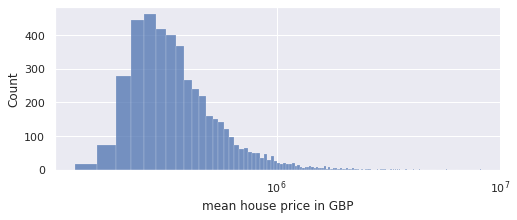

In [75]:
fig = plt.figure(figsize=(8, 3))

ax = sns.histplot(data=grocery_housing, x="mean house price")

ax.set_xscale('log')
ax.set_xlabel('Number of LSOAs')
ax.set_xlabel('mean house price in GBP')

print(grocery_housing["mean house price"].median())

504643.6355953608 377024.72222 1.3384895097168008


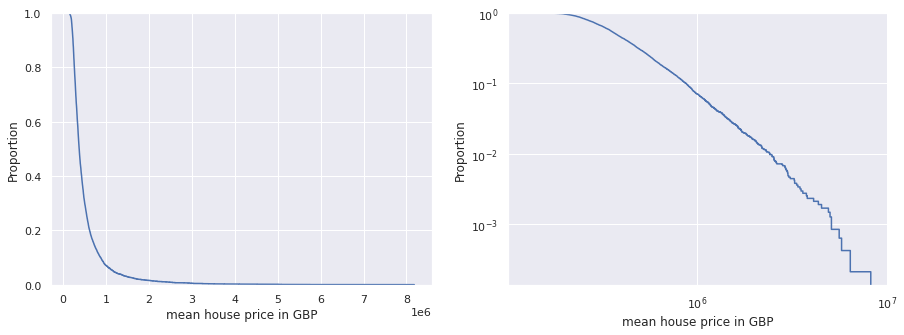

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.ecdfplot(data=grocery_housing, x="mean house price",
             complementary=True, ax=ax[0])
sns.ecdfplot(data=grocery_housing, x="mean house price",
             complementary=True, ax=ax[1])
ax[1].set(xscale="log", yscale="log")

ax[0].set_xlabel('mean house price in GBP')

ax[1].set_xlabel('mean house price in GBP')


price_mean = grocery_housing["mean house price"].mean()
price_median = grocery_housing["mean house price"].median()

print(price_mean, price_median, price_mean / price_median)

The data is skewed to the right, with a long tail of high scores pulling the mean up more than the median. According to the graphs, the data clearly does not follow a normal distribution.

Text(0, 0.5, 'spearman correlation')

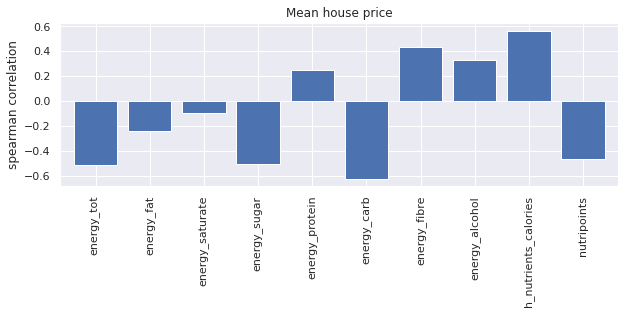

In [77]:
COLS = ["energy_tot", "energy_fat", "energy_saturate", "energy_sugar", "energy_protein",
        "energy_carb", "energy_fibre", "energy_alcohol", "h_nutrients_calories", "nutripoints"]

fig = plt.figure(figsize=(10, 3))
correlation = grocery_housing.corr(method="spearman").loc[COLS]

correlation['mean house price'].plot.bar(
    x=None, y=None, width=0.8, legend=None)

plt.title("Mean house price")
plt.ylabel("spearman correlation")

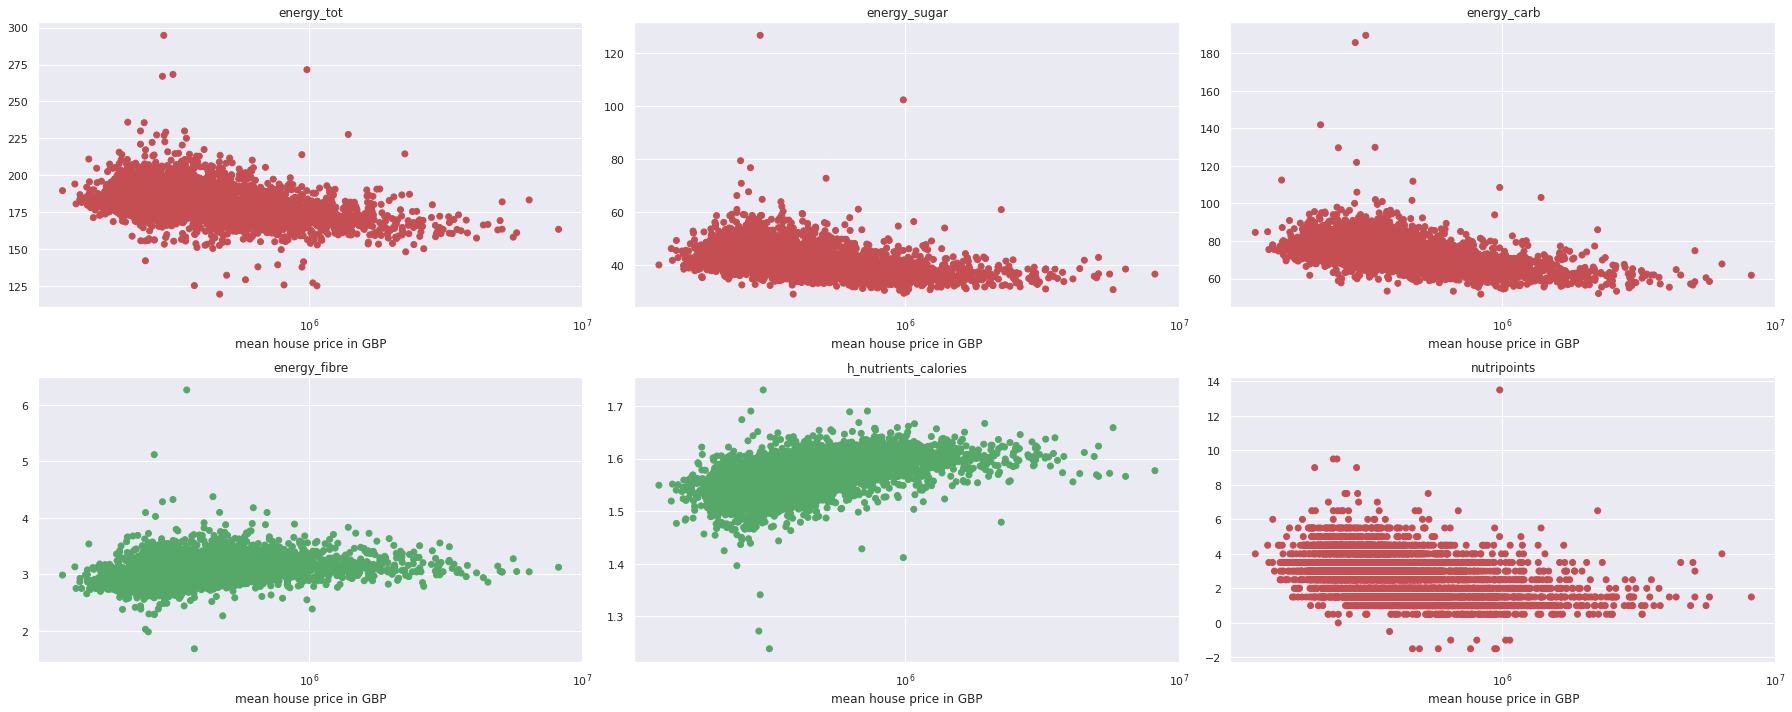

In [78]:
COLS_CORRELATED = ["energy_tot", "energy_sugar", "energy_carb",
                   "energy_fibre", "h_nutrients_calories", "nutripoints"]
# Positively correlated values are encoded in green, negatively correlated in red
colors = ["r", "r", "r", "g", "g", "r"]

N = len(COLS_CORRELATED)

fig, ax = plt.subplots(2, 3, figsize=(25, 10))

for i, col in enumerate(COLS_CORRELATED):
    ax[int(i / 3), i % 3].scatter(grocery_housing["mean house price"],
                                  y=grocery_housing[col], c=[colors[i]] * len(grocery_housing))
    ax[int(i / 3), i % 3].set(xscale="log",
                              title=col, xlabel="mean house price in GBP")

fig.tight_layout()

In [79]:
house_prices_median = grocery_housing["mean house price"].median()


def classify_median(row, median):
    if row["mean house price"] > median:
        return "high"
    else:
        return "low"


grocery_housing["pricing"] = grocery_housing.apply(
    lambda i: classify_median(i, house_prices_median), axis=1)

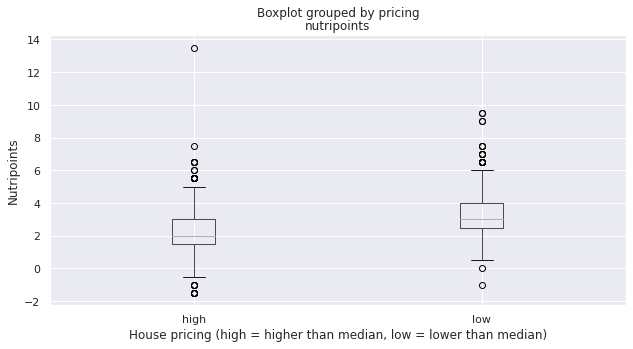

In [80]:
ax = grocery_housing[['nutripoints', 'pricing']
                ].boxplot(by='pricing', figsize=(10, 5))

ax.set(xlabel="House pricing (high = higher than median, low = lower than median)", ylabel="Nutripoints")
plt.show()

#### Predictive Models

In [81]:
grocery_housing.dropna(axis=0, inplace=True)

X_housing = grocery_housing[["mean house price"]]
y_housing = grocery_housing[["nutripoints"]]

X_housing_tr, X_housing_te, y_housing_tr, y_housing_te = train_test_split(X_housing, y_housing, test_size=0.2)
X_housing_tr = X_housing_tr.copy()
X_housing_te = X_housing_te.copy()

scaler_X_housing = StandardScaler()
scaler_y_housing = StandardScaler()

X_housing_tr[X_housing_tr.columns] = scaler_X_housing.fit_transform(X_housing_tr[X_housing_tr.columns])
X_housing_te[X_housing_te.columns] = scaler_X_housing.transform(X_housing_te[X_housing_te.columns])

y_housing_tr = scaler_y_housing.fit_transform(y_housing_tr).ravel()
y_housing_te = scaler_y_housing.transform(y_housing_te).ravel()

print(X_housing_tr.shape, X_housing_te.shape, y_housing_tr.shape, y_housing_te.shape)

(3780, 1) (945, 1) (3780,) (945,)


In [82]:
# Create the models

lin_reg = LinearRegression()
gb_boost_reg = GradientBoostingRegressor(learning_rate=0.1, n_estimators=50)
ridge_reg = Ridge(alpha=.5)
mlp_reg = MLPRegressor(solver='lbfgs', alpha=1e-5,
                       hidden_layer_sizes=(5, 2))
dt_reg = DecisionTreeRegressor()

mse_scores = {}

reg_models = [lin_reg, gb_boost_reg, ridge_reg, mlp_reg, dt_reg]

mse = 'neg_mean_squared_error'

for model in reg_models:
    model_scores = cross_validate(model, X_housing_tr, y_housing_tr, cv=10, scoring=[mse])

    mse_scores[type(model).__name__] = model_scores["test_" + mse]

In [83]:
mse_scores_df = pd.DataFrame(mse_scores).abs()

[Text(0.5, 0, 'Cross-validation run'), Text(0, 0.5, 'MSE')]

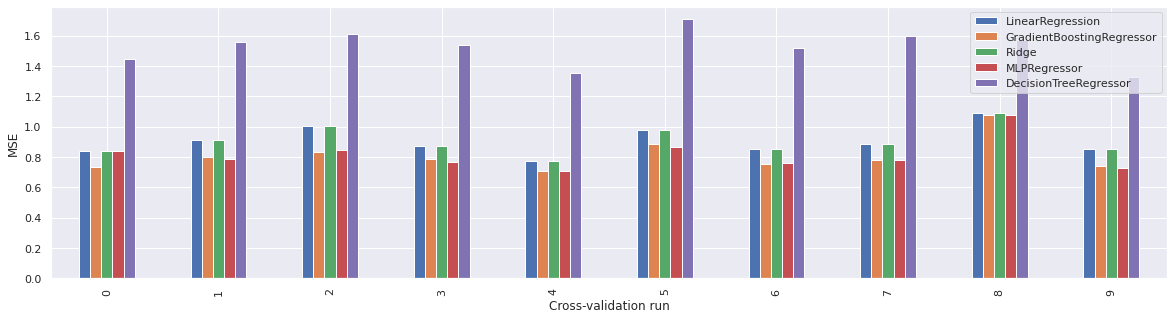

In [84]:
ax = mse_scores_df.plot.bar(figsize=(20, 5))
ax.set(xlabel="Cross-validation run", ylabel="MSE")

In [85]:
best_model = mse_scores_df.mean(axis=0).idxmin()

print(best_model)

GradientBoostingRegressor


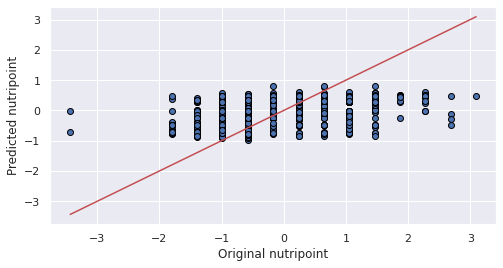

In [86]:
gb_boost_reg = GradientBoostingRegressor(learning_rate=0.1, n_estimators=50)

# Plot the results for the selected best model
gb_boost_reg.fit(X_housing_tr, y_housing_tr)

y_housing_pred = gb_boost_reg.predict(X_housing_te)

fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(y_housing_te, y_housing_pred, edgecolors=(0, 0, 0))
p1 = max(max(y_housing_pred), max(y_housing_te))
p2 = min(min(y_housing_pred), min(y_housing_te))
plt.plot([p1, p2], [p1, p2], 'b-', c='r')
ax.set_xlabel('Original nutripoint')
ax.set_ylabel('Predicted nutripoint')
plt.show()

##### Conclusion

Although we have a finer geographic granularity (LSOA) than in our fist approach to predict the nutritional quality of an area, the housing price does not seem to be enough to make good predictions. Again, the best model does not seem to capture the variance of the data, so the predictions are not very successful.

### C) Fast-Food Chains Analysis

As we have studied if the nutritional properties of the average product per area were correlated to the well-being features, we now want to study the correlation between the nutrients composition and the number of fast-food restaurants per area.

We were able to find the database from the [London Datastore](https://data.london.gov.uk/), the same one as for the well-being features. 

#### Data Import

In [87]:
fast_food = pd.read_excel(
    "data/fast_food_ward.xlsx", sheet_name="Ward Data", header=[3], usecols="E,G")
display(fast_food.head())
print(fast_food.shape)

wellbeing_grocery = pd.read_pickle("data/wellbeing_grocery.pkl")
display(wellbeing_grocery.head())
print(wellbeing_grocery.shape)

grocery_analysis = pd.read_pickle("data/grocery_nutripoints.pkl")
display(grocery_analysis.head())
print(grocery_analysis.shape)

,2015 Ward code,Count of outlets
0,E05001767,10
1,E05001768,10
2,E05001769,22
3,E05001770,81
4,E05001771,5


(5832, 2)


,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,...,Crime rate - Index,Deliberate Fires,Average Capped GCSE and Equivalent Point Score Per Pupil,Unauthorised Absence in All Schools (%),Dependent children in out-of-work families,Public Transport Accessibility,"Homes with access to open space & nature, and % greenspace",Subjective well-being average score,Index Score 2013,nutri_label
0,E05000336,78.864004,32.414378,38.719523,21.433875,71.160848,2.994211,1.741239,176.194176,1.582813,...,5.663200,1.732487,9.104353,14.362369,6.829642,-12.410936,5.496664,0.097080,4.798106,4
1,E05000605,84.561946,33.918637,36.141050,22.015479,69.832483,3.067818,1.697021,181.174746,1.575484,...,-17.140935,6.149262,5.553690,2.833274,2.724538,12.165452,-4.355219,4.064134,0.440499,0
2,E05000252,80.542785,31.635739,33.648475,22.141379,61.322242,3.149138,1.689631,168.845175,1.598050,...,5.477066,9.517488,18.843265,0.391431,4.402315,16.172939,-14.255212,9.646084,4.269507,1
3,E05000427,77.568453,30.521094,35.742617,22.364672,66.992603,2.985766,1.760651,171.672145,1.600125,...,-13.774964,8.269988,4.929764,7.254350,-10.552446,18.059347,-13.621024,1.783860,-2.659193,0
4,E05000595,82.975277,33.302798,37.707033,21.336347,71.447922,2.947414,1.372449,180.079409,1.559561,...,-6.697261,2.509921,-5.728663,-1.420357,3.504061,4.092038,9.694047,4.064134,-0.489500,0


(414, 26)


,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,nutri_class
488,E05009310,67.776372,26.173163,30.149908,20.482709,52.921834,2.972195,3.388133,147.541243,1.680088,-1.5,0
542,E05009400,74.997843,30.267747,33.156419,21.588604,59.817294,3.103980,1.973678,161.481399,1.619959,0.5,0
476,E05000643,76.027079,30.271501,35.110675,20.979538,61.437904,3.009764,1.653409,163.107694,1.597898,1.0,0
486,E05009302,72.005495,29.177570,36.164185,20.553133,61.994290,3.037125,3.490972,161.081015,1.656259,1.0,0
463,E05000630,74.221496,30.006140,35.418521,20.519115,59.341674,3.072843,1.195961,158.351088,1.588668,1.0,0


(510, 12)


#### Data Merging

We compare the number of lines of grocery dataset and fast-food one and try to see how many they have in common. We then merge the two datasets. We also check that there is no null or NA values.

In [88]:
# check if area id is a unique id
is_area_unique = grocery_analysis["area_id"].is_unique
print(is_area_unique)

True


In [89]:
nr_wards_grocery = len(set(grocery_analysis["area_id"].values))
print(nr_wards_grocery)

510


In [90]:
print(grocery_analysis.isna().any().any())

False


In [91]:
nr_wards_fast_food = len(set(fast_food["2015 Ward code"].values))
print(nr_wards_fast_food)

5832


In [92]:
print(fast_food.isna().any())
print("\n")
print(fast_food.isnull().any())

2015 Ward code      False
Count of outlets    False
dtype: bool


2015 Ward code      False
Count of outlets    False
dtype: bool


In [93]:
# calculate number of rows both datasets have in common

nr_wards = len(set(fast_food["2015 Ward code"].values)
               & set(grocery_analysis["area_id"].values))

print(nr_wards)

440


By merging, we lose the information from 70 wards.  

In [94]:
fastfood_grocery = pd.merge(
    left=grocery_analysis, right=fast_food, left_on='area_id', right_on="2015 Ward code")
fastfood_grocery = fastfood_grocery.drop("2015 Ward code", axis=1)
display(fastfood_grocery.head())
print(fastfood_grocery.shape)

,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,nutri_class,Count of outlets
0,E05009310,67.776372,26.173163,30.149908,20.482709,52.921834,2.972195,3.388133,147.541243,1.680088,-1.5,0,33
1,E05009400,74.997843,30.267747,33.156419,21.588604,59.817294,3.103980,1.973678,161.481399,1.619959,0.5,0,7
2,E05000643,76.027079,30.271501,35.110675,20.979538,61.437904,3.009764,1.653409,163.107694,1.597898,1.0,0,9
3,E05009302,72.005495,29.177570,36.164185,20.553133,61.994290,3.037125,3.490972,161.081015,1.656259,1.0,0,6
4,E05000630,74.221496,30.006140,35.418521,20.519115,59.341674,3.072843,1.195961,158.351088,1.588668,1.0,0,1


(440, 13)


We also merge well-being and fast-food in order to check the correlation between the well-being features and the number of fast-food, as we can make some assumptions about how they are linked and maybe prove the reliability of our data. 

In [95]:
fastfood_wellbeing = pd.merge(
    left=wellbeing_grocery, right=fast_food, left_on='area_id', right_on="2015 Ward code")
fastfood_wellbeing = fastfood_wellbeing.drop("2015 Ward code", axis=1)

display(fastfood_wellbeing.head())

print(fastfood_wellbeing.shape)

,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,...,Deliberate Fires,Average Capped GCSE and Equivalent Point Score Per Pupil,Unauthorised Absence in All Schools (%),Dependent children in out-of-work families,Public Transport Accessibility,"Homes with access to open space & nature, and % greenspace",Subjective well-being average score,Index Score 2013,nutri_label,Count of outlets
0,E05000336,78.864004,32.414378,38.719523,21.433875,71.160848,2.994211,1.741239,176.194176,1.582813,...,1.732487,9.104353,14.362369,6.829642,-12.410936,5.496664,0.097080,4.798106,4,15
1,E05000605,84.561946,33.918637,36.141050,22.015479,69.832483,3.067818,1.697021,181.174746,1.575484,...,6.149262,5.553690,2.833274,2.724538,12.165452,-4.355219,4.064134,0.440499,0,13
2,E05000252,80.542785,31.635739,33.648475,22.141379,61.322242,3.149138,1.689631,168.845175,1.598050,...,9.517488,18.843265,0.391431,4.402315,16.172939,-14.255212,9.646084,4.269507,1,8
3,E05000427,77.568453,30.521094,35.742617,22.364672,66.992603,2.985766,1.760651,171.672145,1.600125,...,8.269988,4.929764,7.254350,-10.552446,18.059347,-13.621024,1.783860,-2.659193,0,14
4,E05000595,82.975277,33.302798,37.707033,21.336347,71.447922,2.947414,1.372449,180.079409,1.559561,...,2.509921,-5.728663,-1.420357,3.504061,4.092038,9.694047,4.064134,-0.489500,0,25


(407, 27)


#### Exploratory Data Analysis

#### a) Distribution of the values: describe, boxplot, distplot

In [96]:
# Understanding better how the values are distributed
fastfood_grocery.describe()

,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,nutri_class,Count of outlets
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,80.653871,31.811113,40.031539,21.093016,71.787149,3.027993,1.679636,178.241665,1.573155,7.575000,1.931818,14.397727
std,2.909051,1.388606,3.306468,0.855441,5.520788,0.117759,0.364883,7.281531,0.025258,2.703463,1.121294,13.933081
min,67.111854,26.173163,30.149908,17.596480,52.921834,2.750710,0.715793,147.541243,1.465237,-1.500000,0.000000,1.000000
25%,78.989452,30.955484,37.927397,20.696160,68.159543,2.947692,1.433929,173.856481,1.556885,6.000000,1.000000,7.000000
50%,80.448641,31.660923,39.643719,21.229909,71.872886,3.022663,1.660522,178.583441,1.573913,7.500000,2.000000,11.000000
75%,82.164445,32.544245,42.018439,21.675982,75.687417,3.093645,1.873801,182.536718,1.590158,9.500000,3.000000,18.000000
max,92.440804,38.690892,48.719140,23.005837,84.618879,3.617668,3.490972,197.674474,1.680088,15.000000,4.000000,147.000000


<AxesSubplot:ylabel='Count of outlets'>

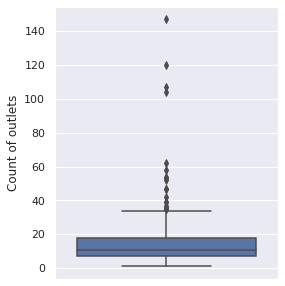

In [97]:
fig = plt.figure(figsize=(4, 5))

sns.boxplot(y=fastfood_grocery["Count of outlets"])

There are many outliers for the number of outlets going up to 147, whereas the median is at 11. Due to this phenomenom, the mean is quite high whereas 75% of the values are between 1 and 18.

In [98]:
# List of columns of interest in the nutritional dataset

COLUMNS_GROCERY_FAST = COLUMNS_GROCERY + ['Count of outlets']

# Selection of the numerical columns of interest in the fastfood_grocery dataset
fastfood_grocery_analysis = fastfood_grocery[COLUMNS_GROCERY_FAST].copy()

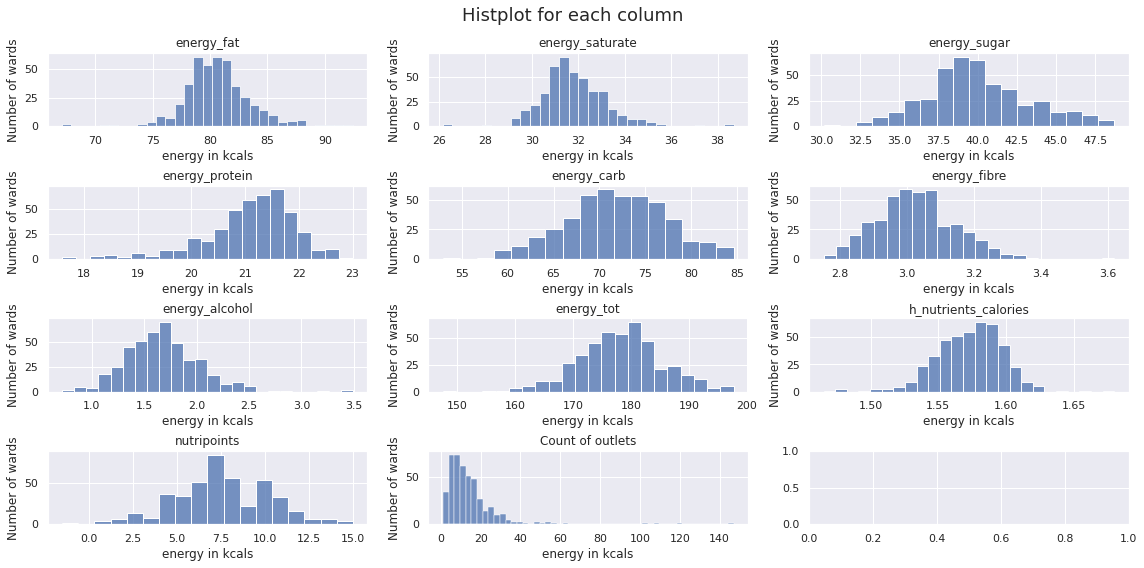

In [99]:
fig, ax = plt.subplots(4, 3, figsize=(16, 8), sharey=False)

for i in range(len(COLUMNS_GROCERY_FAST)):
    sbplt = ax[int(i/3), i % 3]

    sns.histplot(data=fastfood_grocery_analysis.iloc[:, i], ax=sbplt)
    sbplt.set_xlabel('energy in kcals')
    sbplt.set_ylabel('Number of wards')
    sbplt.set_title(fastfood_grocery_analysis.columns[i], wrap=True)

fig.tight_layout()
fig.subplots_adjust(top=0.9)

fig.suptitle('Histplot for each column', fontsize=18);

Most of the nutritional variables seem to be normally distributed. On the other side, the number of outlets is more logarithmic. Most of the areas have between 5 and 10 fast foods but it goes up to 140! 

#### b) Correlation between the number of fast foods and the different nutritional variables

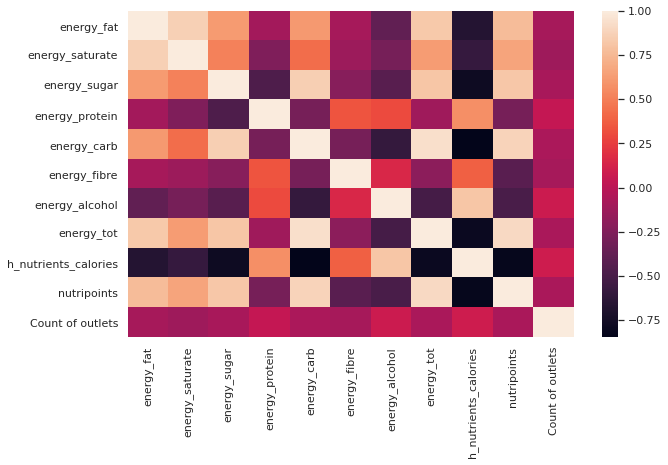

In [100]:
# Heatmap to visualize the correlation between the variables
fig = plt.figure(figsize=(10, 6))
sns.heatmap(fastfood_grocery_analysis.corr());

The correlation with the number of oulets (the last column or row) seems really low as the colours are mainly red, corresponding to values around 0. We will display the correlation table for the count of outlets to better understand the importance of the correlation with the nutritional variables. 

In [101]:
correlation = fastfood_grocery_analysis.corr(method="spearman")
display(correlation[["Count of outlets"]])

,Count of outlets
energy_fat,-0.010292
energy_saturate,-0.105991
energy_sugar,-0.012535
energy_protein,0.052572
energy_carb,0.034797
energy_fibre,-0.213410
energy_alcohol,0.000670
energy_tot,0.028182
h_nutrients_calories,-0.018201
nutripoints,0.035695


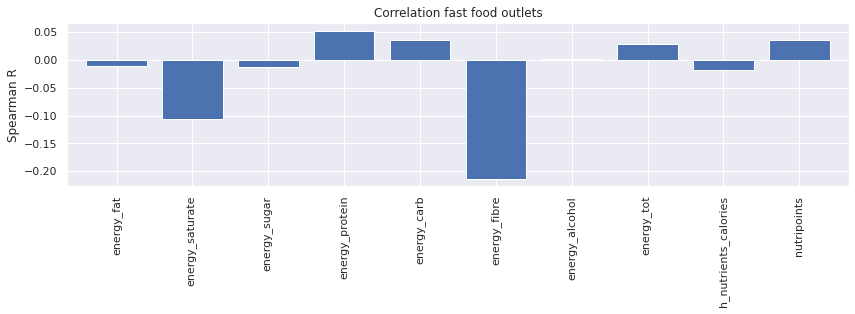

In [102]:
plt.figure(figsize=(14, 3))
correlation["Count of outlets"][:-1].plot.bar(
    x=None, y=None, width=0.8, legend=None)
plt.ylabel("Spearman R")
plt.title("Correlation fast food outlets")
plt.show()

**The number of fast food restaurants has a very low correlation with the Nutripoints.**   
Furthermore, there is almost no correlation with other variables. Therefore, it is hardly justifiable to predict the nutritional informations of the average product of an area from the number of fast-food.

We will however try to further investigate this correlation. 

#### c) Correlation between the number of fast food and the well-being measures

In [103]:
# List of columns of interest in the wellbeing dataset
COLUMNS_SCORES = [
    'Life Expectancy',
    'Childhood Obesity',
    'Incapacity Benefit rate',
    'Unemployment rate',
    'Crime rate - Index',
    'Deliberate Fires',
    'Average Capped GCSE and Equivalent Point Score Per Pupil',
    'Unauthorised Absence in All Schools (%)',
    'Dependent children in out-of-work families',
    'Public Transport Accessibility',
    'Homes with access to open space & nature, and % greenspace',
    'Subjective well-being average score',
    'Index Score 2013',
    'nutripoints',
    'Count of outlets'
]

# Selection of the numerical columns of interest in the wellbeing_grocery dataset
fastfood_wellbeing_analysis = fastfood_wellbeing[COLUMNS_SCORES].copy()

In [104]:
correlation = fastfood_wellbeing_analysis.corr(method="spearman")
display(correlation[["Count of outlets"]])

,Count of outlets
Life Expectancy,-0.258841
Childhood Obesity,-0.228199
Incapacity Benefit rate,-0.169289
Unemployment rate,-0.329209
Crime rate - Index,-0.397001
Deliberate Fires,-0.137302
Average Capped GCSE and Equivalent Point Score Per Pupil,-0.278795
Unauthorised Absence in All Schools (%),-0.211107
Dependent children in out-of-work families,-0.280465
Public Transport Accessibility,0.440609


For the plot, we only keep the variables that have a spearman score higher than 0.2.

In [105]:
fastfood_wellbeing_analysis.drop(columns=['Incapacity Benefit rate',
                                          'Deliberate Fires',
                                          'Average Capped GCSE and Equivalent Point Score Per Pupil',
                                          'Unauthorised Absence in All Schools (%)', 'Dependent children in out-of-work families',
                                          'Homes with access to open space & nature, and % greenspace',
                                          'Subjective well-being average score'], inplace=True)
fastfood_wellbeing_analysis.to_pickle("plot_data/fastfood_wellbeing.pkl")

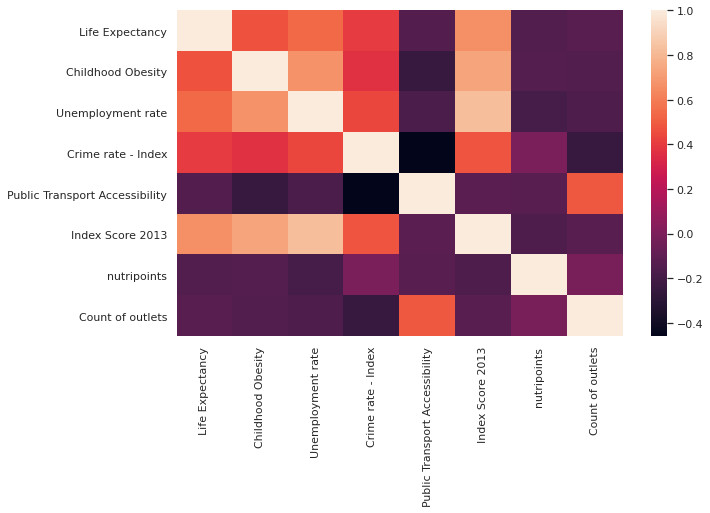

In [106]:
# Heatmap to visualize the correlation between the variables
fig = plt.figure(figsize=(10, 6))
sns.heatmap(fastfood_wellbeing_analysis.corr());

In [107]:
correlation_shorten = fastfood_wellbeing_analysis.corr(method="spearman")

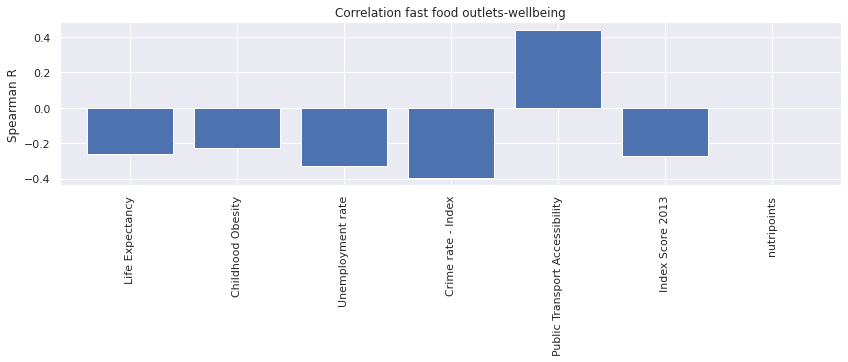

In [108]:
plt.figure(figsize=(14, 3))
correlation_shorten.iloc[0:7, 7].plot.bar(
    x=None, y=None, width=0.8, legend=None)
plt.ylabel("Spearman R")
plt.title("Correlation fast food outlets-wellbeing")
plt.show()

When talking about fast-food and its relation with well-being variables, we are biased. It is well correlated with Public Transport, which could facilitate the access to the consumers and increase customer rate. On the other hand, Crime rate should be low (as we can see here it is negatively correlated to the number of fast-food) as the clients should feel safe when coming to the restaurants. However, we would have expected that it would be positively correlated with Childhood Obesity and Unemployment rate. We think that as fast-food restaurants are cheap, the chains won't target the higher social classes, but mostly the ones that need comfort foods. Furthermore, fast-food chains do not usually serve healthy food, but mostly products rich in fat and sugar, causing obesity.

Therefore, some results seem plausible, but not all of them. Thus, it is difficult to make a decisive conclusion about the link between fast-food and the nutripoints of the average product of an area.

#### Conclusion 

Having the average products per area, it is difficult to have a representation of how healthy the inhabitants of an area consume. A high nutripoint value does not necessary mean that all the consumers of this area consume more fatty or sugary products. Furthermore, an unhealthy average product is not linked to a high number of fast-food restaurants. However, it could be interesting to see if the richest areas have less fast-food restaurants, as richer people may prefer to go to other types of restaurants.